# Constants

In [1]:
DATASET_PATH = '../data/breast_cancer.csv'

# Imports

In [2]:
# Core libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# scikit-learn utilities
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline

# Classification algorithms
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.ensemble import RandomForestClassifier

# Boosting algorithm
# import lightgbm as lgb

# Add path to local project source code
import sys
sys.path.append('../src')

# Import custom Repeated Nested CV class
from RepeatedNestedCV import RepeatedNestedCV

# Analysis

## Algorithms & Params

In [3]:
# We use lambda **kwargs so that Optuna can pass hyperparameters into the constructor.
estimators = {
    "LR": lambda **kwargs: LogisticRegression(random_state=42, **kwargs),
    "GNB": GaussianNB,
    # "LDA": LinearDiscriminantAnalysis,
    # "SVC": lambda **kwargs: SVC(probability=True, **kwargs), # Without the "probability" fixed value, AUC will be none for SVM
    # "RF": RandomForestClassifier,
    # "LGBM": lambda **kwargs: lgb.LGBMClassifier(random_state=42, **kwargs),
}

param_spaces = {
    "LR": lambda trial: {
        'C': trial.suggest_float('C', 1e-4, 1e2, log=True),
        'l1_ratio': trial.suggest_float('l1_ratio', 0, 1),
        'solver': 'saga', # Fixed for Elastic Net Regularization
        'penalty': 'elasticnet', # Fixed for Elastic Net Regularization
        'max_iter': 1000
    },
    "GNB": lambda trial: {
        'var_smoothing': trial.suggest_float('var_smoothing', 1e-11, 1e-7, log=True)
    },
    # "LDA": lambda trial: {
    #     'solver': trial.suggest_categorical('solver', ['svd', 'lsqr', 'eigen'])
    # },
    # "SVC": lambda trial: {
    #     'C': trial.suggest_float('C', 1e-3, 1e2, log=True),
    #     'gamma': trial.suggest_float('gamma', 1e-4, 1e0, log=True),
    # },
    # "RF": lambda trial: {
    #     'n_estimators': trial.suggest_int('n_estimators', 50, 200),
    #     'max_depth': trial.suggest_int('max_depth', 3, 20),
    #     'min_samples_split': trial.suggest_int('min_samples_split', 2, 10),
    #     'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 5)
    # },
    # "LGBM": lambda trial: {
    #     'n_estimators': trial.suggest_int('n_estimators', 50, 200),
    #     'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3),
    #     'num_leaves': trial.suggest_int('num_leaves', 20, 100),
    #     'max_depth': trial.suggest_int('max_depth', 3, 12),
    #     'min_child_samples': trial.suggest_int('min_child_samples', 5, 30)
    # }
}

## Prepare Dataset

In [13]:
df = pd.read_csv(DATASET_PATH)
df.drop('id', axis=1, inplace=True)
df['diagnosis'] = df['diagnosis'].replace({'M': '1', 'B': '0'}).astype(int)
df.head()

,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,...,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst
0,1,14.68,20.13,94.74,684.5,0.09867,0.07200,0.07395,0.05259,0.1586,...,19.07,30.88,123.40,1138.0,0.1464,0.1871,0.29140,0.16090,0.3029,0.08216
1,0,11.50,18.45,73.28,407.4,0.09345,0.05991,0.02638,0.02069,0.1834,...,12.97,22.46,83.12,508.9,0.1183,0.1049,0.08105,0.06544,0.2740,NaN
2,1,15.85,23.95,103.70,782.7,0.08401,0.10020,0.09938,0.05364,0.1847,...,16.84,27.66,112.00,876.5,0.1131,0.1924,0.23220,0.11190,0.2809,0.06287
3,1,18.82,21.97,123.70,1110.0,0.10180,0.13890,0.15940,0.08744,0.1943,...,22.66,30.93,145.30,1603.0,0.1390,0.3463,0.39120,0.17080,0.3007,0.08314
4,0,12.95,16.02,83.14,513.7,0.10050,0.07943,0.06155,0.03370,0.1730,...,13.74,19.93,88.81,585.4,0.1483,NaN,0.22410,0.10560,0.3380,0.09584


## nCV

In [10]:
# Extract X and y from dataframe
X = df.drop(columns=['diagnosis']).values
y = df['diagnosis'].values

In [11]:
rncv = RepeatedNestedCV(
    X=X,
    y=y,
    estimators=estimators,
    param_spaces=param_spaces,
)

rncv.run()

[I 2025-04-25 14:05:33,227] A new study created in memory with name: no-name-cb2d5dc4-699c-41ec-9ed6-8a4aa896a6b2
[I 2025-04-25 14:05:33,269] Trial 0 finished with value: 0.7641472868217054 and parameters: {'C': 0.004211670349814923, 'l1_ratio': 0.8133293097351302}. Best is trial 0 with value: 0.7641472868217054.
[I 2025-04-25 14:05:33,290] Trial 1 finished with value: 0.0 and parameters: {'C': 0.00018758031750132527, 'l1_ratio': 0.4795226888558983}. Best is trial 0 with value: 0.7641472868217054.
[I 2025-04-25 14:05:33,339] Trial 2 finished with value: 0.9389957365189563 and parameters: {'C': 94.09173184156597, 'l1_ratio': 0.2297176354658269}. Best is trial 2 with value: 0.9389957365189563.
[I 2025-04-25 14:05:33,350] Trial 3 finished with value: 0.0 and parameters: {'C': 0.0021867323284403568, 'l1_ratio': 0.8696903207451734}. Best is trial 2 with value: 0.9389957365189563.
[I 2025-04-25 14:05:33,395] Trial 4 finished with value: 0.9389957365189563 and parameters: {'C': 26.20862710313


>>> Repetition 1/10

Outer Fold 1/5
Tuning: LR


[I 2025-04-25 14:05:33,441] Trial 5 finished with value: 0.9389957365189563 and parameters: {'C': 80.3802917927199, 'l1_ratio': 0.5678455760060842}. Best is trial 2 with value: 0.9389957365189563.
[I 2025-04-25 14:05:33,455] Trial 6 finished with value: 0.9486574933003505 and parameters: {'C': 0.14654367499602147, 'l1_ratio': 0.09726132410662669}. Best is trial 6 with value: 0.9486574933003505.
[I 2025-04-25 14:05:33,467] Trial 7 finished with value: 0.18943191311612365 and parameters: {'C': 0.0011844805637241753, 'l1_ratio': 0.32961837590837106}. Best is trial 6 with value: 0.9486574933003505.
[I 2025-04-25 14:05:33,478] Trial 8 finished with value: 0.09786756453423119 and parameters: {'C': 0.0011436489652960715, 'l1_ratio': 0.34530205885250465}. Best is trial 6 with value: 0.9486574933003505.
[I 2025-04-25 14:05:33,488] Trial 9 finished with value: 0.0 and parameters: {'C': 0.00014627482455462526, 'l1_ratio': 0.8067828678862676}. Best is trial 6 with value: 0.9486574933003505.
[I 202

Tuning: SVC


[I 2025-04-25 14:05:34,616] Trial 7 finished with value: 0.9416970998925885 and parameters: {'C': 14.137094026629239, 'gamma': 0.00041442081812190424}. Best is trial 7 with value: 0.9416970998925885.
[I 2025-04-25 14:05:34,645] Trial 8 finished with value: 0.0 and parameters: {'C': 0.0026448719561296815, 'gamma': 0.1337545908521152}. Best is trial 7 with value: 0.9416970998925885.
[I 2025-04-25 14:05:34,672] Trial 9 finished with value: 0.0 and parameters: {'C': 0.044508477790671304, 'gamma': 0.0005336671521064262}. Best is trial 7 with value: 0.9416970998925885.
[I 2025-04-25 14:05:34,692] Trial 10 finished with value: 0.9346222699606158 and parameters: {'C': 63.83008194725295, 'gamma': 0.00011226025798861055}. Best is trial 7 with value: 0.9416970998925885.
[I 2025-04-25 14:05:34,712] Trial 11 finished with value: 0.9460204967865207 and parameters: {'C': 2.815873421934096, 'gamma': 0.029707087981635422}. Best is trial 11 with value: 0.9460204967865207.
[I 2025-04-25 14:05:34,731] Tri


Outer Fold 2/5
Tuning: LR


/opt/anaconda3/envs/bioinformatics/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
[I 2025-04-25 14:05:35,913] Trial 10 finished with value: 0.9549216874426039 and parameters: {'C': 62.17771850091345, 'l1_ratio': 0.7333361941549618}. Best is trial 4 with value: 0.9627912621359224.
[I 2025-04-25 14:05:35,952] Trial 11 finished with value: 0.9547357065803667 and parameters: {'C': 1.622739398807315, 'l1_ratio': 0.987072834415823}. Best is trial 4 with value: 0.9627912621359224.
[I 2025-04-25 14:05:35,984] Trial 12 finished with value: 0.9513725490196078 and parameters: {'C': 1.4116519952789521, 'l1_ratio': 0.7021200577544694}. Best is trial 4 with value: 0.9627912621359224.
[I 2025-04-25 14:05:35,997] Trial 13 finished with value: 0.0 and parameters: {'C': 0.00011155591102228755, 'l1_ratio': 0.6926450465059094}. Best is trial 4 with value: 0.9627912621359224.
[I 2025-04-25 1

Tuning: SVC


[I 2025-04-25 14:05:37,167] Trial 8 finished with value: 0.0 and parameters: {'C': 0.030892618811987703, 'gamma': 0.14984529280643338}. Best is trial 4 with value: 0.963226240991446.
[I 2025-04-25 14:05:37,202] Trial 9 finished with value: 0.5275523736737997 and parameters: {'C': 7.474894666064647, 'gamma': 0.7486428063572428}. Best is trial 4 with value: 0.963226240991446.
[I 2025-04-25 14:05:37,222] Trial 10 finished with value: 0.9524893290649593 and parameters: {'C': 75.74568115074408, 'gamma': 0.00011793122757790848}. Best is trial 4 with value: 0.963226240991446.
[I 2025-04-25 14:05:37,242] Trial 11 finished with value: 0.9446510237301649 and parameters: {'C': 1.558798712900453, 'gamma': 0.002016599926414717}. Best is trial 4 with value: 0.963226240991446.
[I 2025-04-25 14:05:37,264] Trial 12 finished with value: 0.9374231325737022 and parameters: {'C': 0.48443364314129783, 'gamma': 0.006021697896995264}. Best is trial 4 with value: 0.963226240991446.
[I 2025-04-25 14:05:37,282] 


Outer Fold 3/5
Tuning: LR


[I 2025-04-25 14:05:38,251] Trial 9 finished with value: 0.0 and parameters: {'C': 0.00045607242547932925, 'l1_ratio': 0.3677595655135174}. Best is trial 4 with value: 0.950732396518478.
/opt/anaconda3/envs/bioinformatics/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
[I 2025-04-25 14:05:38,294] Trial 10 finished with value: 0.94170840053193 and parameters: {'C': 97.57825610889869, 'l1_ratio': 0.42352624040805964}. Best is trial 4 with value: 0.950732396518478.
[I 2025-04-25 14:05:38,310] Trial 11 finished with value: 0.9449294231249118 and parameters: {'C': 0.0552765406413838, 'l1_ratio': 0.29661220327815396}. Best is trial 4 with value: 0.950732396518478.
[I 2025-04-25 14:05:38,325] Trial 12 finished with value: 0.9518835259814642 and parameters: {'C': 0.054114608746918896, 'l1_ratio': 0.22774835771793284}. Best is trial 12 with value: 0.9518835259814642.
[I 2025-04-25

Tuning: SVC


[I 2025-04-25 14:05:39,358] Trial 7 finished with value: 0.9116501377042762 and parameters: {'C': 54.73523930856589, 'gamma': 0.23159112132952403}. Best is trial 0 with value: 0.9445969044621694.
[I 2025-04-25 14:05:39,385] Trial 8 finished with value: 0.0 and parameters: {'C': 0.03692990491773294, 'gamma': 0.0008270760143499904}. Best is trial 0 with value: 0.9445969044621694.
[I 2025-04-25 14:05:39,412] Trial 9 finished with value: 0.3341560066740823 and parameters: {'C': 0.06549703342404425, 'gamma': 0.0020152756175274376}. Best is trial 0 with value: 0.9445969044621694.
[I 2025-04-25 14:05:39,441] Trial 10 finished with value: 0.484152585765489 and parameters: {'C': 1.153159289971766, 'gamma': 0.00013104607928086305}. Best is trial 0 with value: 0.9445969044621694.
[I 2025-04-25 14:05:39,460] Trial 11 finished with value: 0.9518113538157941 and parameters: {'C': 3.428386450502788, 'gamma': 0.005504433388313536}. Best is trial 11 with value: 0.9518113538157941.
[I 2025-04-25 14:05:3


Outer Fold 4/5
Tuning: LR


[I 2025-04-25 14:05:40,532] Trial 11 finished with value: 0.9539118579666838 and parameters: {'C': 1.5116867411353745, 'l1_ratio': 0.4274553900197173}. Best is trial 11 with value: 0.9539118579666838.
[I 2025-04-25 14:05:40,555] Trial 12 finished with value: 0.9534480458850206 and parameters: {'C': 0.6332773466470745, 'l1_ratio': 0.280236968044895}. Best is trial 11 with value: 0.9539118579666838.
[I 2025-04-25 14:05:40,584] Trial 13 finished with value: 0.9539118579666838 and parameters: {'C': 1.8304642722939188, 'l1_ratio': 0.28486887019288937}. Best is trial 11 with value: 0.9539118579666838.
/opt/anaconda3/envs/bioinformatics/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
[I 2025-04-25 14:05:40,634] Trial 14 finished with value: 0.9434106069612311 and parameters: {'C': 92.36751391667075, 'l1_ratio': 0.28887122144197813}. Best is trial 11 with value: 0.953911857966683

Tuning: SVC


[I 2025-04-25 14:05:41,661] Trial 9 finished with value: 0.0 and parameters: {'C': 0.0038937449630870227, 'gamma': 0.0020616456158214767}. Best is trial 4 with value: 0.9531623397602779.
[I 2025-04-25 14:05:41,694] Trial 10 finished with value: 0.924530790909636 and parameters: {'C': 97.73114269105143, 'gamma': 0.18538580828132992}. Best is trial 4 with value: 0.9531623397602779.
[I 2025-04-25 14:05:41,714] Trial 11 finished with value: 0.953958633958634 and parameters: {'C': 4.246197253228054, 'gamma': 0.03468891763422632}. Best is trial 11 with value: 0.953958633958634.
[I 2025-04-25 14:05:41,743] Trial 12 finished with value: 0.9198830409356725 and parameters: {'C': 0.07871473966405772, 'gamma': 0.09272707445279461}. Best is trial 11 with value: 0.953958633958634.
[I 2025-04-25 14:05:41,761] Trial 13 finished with value: 0.9527009682864237 and parameters: {'C': 3.8979625909444757, 'gamma': 0.00503020805963473}. Best is trial 11 with value: 0.953958633958634.
[I 2025-04-25 14:05:41,7


Outer Fold 5/5
Tuning: LR


[I 2025-04-25 14:05:42,771] Trial 9 finished with value: 0.9696268810554525 and parameters: {'C': 0.3632379621619523, 'l1_ratio': 0.5572373430963101}. Best is trial 9 with value: 0.9696268810554525.
/opt/anaconda3/envs/bioinformatics/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
[I 2025-04-25 14:05:42,826] Trial 10 finished with value: 0.9509436380531257 and parameters: {'C': 81.6208889884815, 'l1_ratio': 0.7869914688613242}. Best is trial 9 with value: 0.9696268810554525.
[I 2025-04-25 14:05:42,854] Trial 11 finished with value: 0.9631649831649831 and parameters: {'C': 0.8262064787737203, 'l1_ratio': 0.35575479353406025}. Best is trial 9 with value: 0.9696268810554525.
[I 2025-04-25 14:05:42,888] Trial 12 finished with value: 0.9634983498349835 and parameters: {'C': 1.9595505636602808, 'l1_ratio': 0.36257902048236657}. Best is trial 9 with value: 0.9696268810554525.
[I

Tuning: SVC


[I 2025-04-25 14:05:44,026] Trial 8 finished with value: 0.9637597877434803 and parameters: {'C': 1.9814375508695685, 'gamma': 0.03456674657131745}. Best is trial 4 with value: 0.9698269010574526.
[I 2025-04-25 14:05:44,048] Trial 9 finished with value: 0.937266944505374 and parameters: {'C': 0.4348215169851938, 'gamma': 0.002595586955682437}. Best is trial 4 with value: 0.9698269010574526.
[I 2025-04-25 14:05:44,065] Trial 10 finished with value: 0.9597306397306397 and parameters: {'C': 90.48292396588091, 'gamma': 0.0013505321256166308}. Best is trial 4 with value: 0.9698269010574526.
[I 2025-04-25 14:05:44,083] Trial 11 finished with value: 0.9322162985529322 and parameters: {'C': 99.84440753587286, 'gamma': 0.024971600697457335}. Best is trial 4 with value: 0.9698269010574526.
[I 2025-04-25 14:05:44,101] Trial 12 finished with value: 0.9505571733643953 and parameters: {'C': 12.446449927741096, 'gamma': 0.03797292395645519}. Best is trial 4 with value: 0.9698269010574526.
[I 2025-04-


>>> Repetition 2/10

Outer Fold 1/5
Tuning: LR


[I 2025-04-25 14:05:45,159] Trial 11 finished with value: 0.9605824088976572 and parameters: {'C': 2.928184954858212, 'l1_ratio': 0.19461688000553043}. Best is trial 9 with value: 0.9636886018698957.
[I 2025-04-25 14:05:45,183] Trial 12 finished with value: 0.9601902520349123 and parameters: {'C': 0.8910466915493311, 'l1_ratio': 0.011317048584268963}. Best is trial 9 with value: 0.9636886018698957.
[I 2025-04-25 14:05:45,212] Trial 13 finished with value: 0.9601902520349123 and parameters: {'C': 1.0577081183521873, 'l1_ratio': 0.363029882280441}. Best is trial 9 with value: 0.9636886018698957.
[I 2025-04-25 14:05:45,268] Trial 14 finished with value: 0.9570723948376 and parameters: {'C': 13.384984854628195, 'l1_ratio': 0.33650742735773}. Best is trial 9 with value: 0.9636886018698957.
[I 2025-04-25 14:05:45,284] Trial 15 finished with value: 0.9460947712418301 and parameters: {'C': 0.16058820008645186, 'l1_ratio': 0.6469714232631332}. Best is trial 9 with value: 0.9636886018698957.
[I 

Tuning: SVC


[I 2025-04-25 14:05:46,596] Trial 7 finished with value: 0.4546312323931711 and parameters: {'C': 16.16078015430881, 'gamma': 0.8539231709218356}. Best is trial 0 with value: 0.9567623429009567.
[I 2025-04-25 14:05:46,611] Trial 8 finished with value: 0.9589031488884213 and parameters: {'C': 10.634137858723472, 'gamma': 0.0014241234426210705}. Best is trial 8 with value: 0.9589031488884213.
[I 2025-04-25 14:05:46,626] Trial 9 finished with value: 0.9629485883700558 and parameters: {'C': 6.613690173130541, 'gamma': 0.01117259146003933}. Best is trial 9 with value: 0.9629485883700558.
[I 2025-04-25 14:05:46,644] Trial 10 finished with value: 0.9520939636919019 and parameters: {'C': 75.12887099568336, 'gamma': 0.00013066485974637924}. Best is trial 9 with value: 0.9629485883700558.
[I 2025-04-25 14:05:46,664] Trial 11 finished with value: 0.9589690721649484 and parameters: {'C': 2.8217597981713727, 'gamma': 0.001726243440443381}. Best is trial 9 with value: 0.9629485883700558.
[I 2025-04-


Outer Fold 2/5
Tuning: LR


[I 2025-04-25 14:05:47,738] Trial 9 finished with value: 0.9502911467617349 and parameters: {'C': 21.870079542815667, 'l1_ratio': 0.49277515530776794}. Best is trial 2 with value: 0.9502911467617349.
[I 2025-04-25 14:05:47,753] Trial 10 finished with value: 0.9025081336882579 and parameters: {'C': 0.05196506943162633, 'l1_ratio': 0.9836515925711401}. Best is trial 2 with value: 0.9502911467617349.
[I 2025-04-25 14:05:47,794] Trial 11 finished with value: 0.9502911467617349 and parameters: {'C': 68.01514675259577, 'l1_ratio': 0.7006676384451282}. Best is trial 2 with value: 0.9502911467617349.
[I 2025-04-25 14:05:47,834] Trial 12 finished with value: 0.9502911467617349 and parameters: {'C': 88.63797304153277, 'l1_ratio': 0.8413607004512925}. Best is trial 2 with value: 0.9502911467617349.
[I 2025-04-25 14:05:47,868] Trial 13 finished with value: 0.947188836530712 and parameters: {'C': 4.685394524751568, 'l1_ratio': 0.6001783028134824}. Best is trial 2 with value: 0.9502911467617349.
[I 

Tuning: SVC


[I 2025-04-25 14:05:49,259] Trial 8 finished with value: 0.9292929292929294 and parameters: {'C': 26.405176098816334, 'gamma': 0.0014397164688352364}. Best is trial 0 with value: 0.9395211630006539.
[I 2025-04-25 14:05:49,275] Trial 9 finished with value: 0.9451530612244898 and parameters: {'C': 7.11073928055624, 'gamma': 0.0014382944311461194}. Best is trial 9 with value: 0.9451530612244898.
[I 2025-04-25 14:05:49,297] Trial 10 finished with value: 0.9222185222185223 and parameters: {'C': 68.69189059364616, 'gamma': 0.0650345808985764}. Best is trial 9 with value: 0.9451530612244898.
[I 2025-04-25 14:05:49,315] Trial 11 finished with value: 0.9395211630006539 and parameters: {'C': 2.842660442807142, 'gamma': 0.013461037585199594}. Best is trial 9 with value: 0.9451530612244898.
[I 2025-04-25 14:05:49,333] Trial 12 finished with value: 0.9387585034013606 and parameters: {'C': 3.16068612982454, 'gamma': 0.006835190770983722}. Best is trial 9 with value: 0.9451530612244898.
[I 2025-04-25


Outer Fold 3/5
Tuning: LR


/opt/anaconda3/envs/bioinformatics/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
[I 2025-04-25 14:05:50,420] Trial 10 finished with value: 0.9473241441791238 and parameters: {'C': 32.017606375336975, 'l1_ratio': 0.9797376716131693}. Best is trial 5 with value: 0.957095709570957.
[I 2025-04-25 14:05:50,433] Trial 11 finished with value: 0.8964909651746047 and parameters: {'C': 0.01654228111090249, 'l1_ratio': 0.7886353827438133}. Best is trial 5 with value: 0.957095709570957.
[I 2025-04-25 14:05:50,467] Trial 12 finished with value: 0.9536633663366336 and parameters: {'C': 1.4902352855268228, 'l1_ratio': 0.9760602629787049}. Best is trial 5 with value: 0.957095709570957.
[I 2025-04-25 14:05:50,511] Trial 13 finished with value: 0.9473241441791238 and parameters: {'C': 2.8537895375077786, 'l1_ratio': 0.9714435140846556}. Best is trial 5 with value: 0.957095709570957.
[I 2

Tuning: SVC


[I 2025-04-25 14:05:51,651] Trial 8 finished with value: 0.0 and parameters: {'C': 0.014819717781304411, 'gamma': 0.06585907533248196}. Best is trial 4 with value: 0.952996632996633.
[I 2025-04-25 14:05:51,670] Trial 9 finished with value: 0.9445042530568847 and parameters: {'C': 1.0451215649387764, 'gamma': 0.0031742115972245256}. Best is trial 4 with value: 0.952996632996633.
[I 2025-04-25 14:05:51,711] Trial 10 finished with value: 0.590487270004279 and parameters: {'C': 68.9203904824857, 'gamma': 0.7387588495289543}. Best is trial 4 with value: 0.952996632996633.
[I 2025-04-25 14:05:51,729] Trial 11 finished with value: 0.952996632996633 and parameters: {'C': 11.972979467012083, 'gamma': 0.002541715434029506}. Best is trial 4 with value: 0.952996632996633.
[I 2025-04-25 14:05:51,748] Trial 12 finished with value: 0.9623989898989899 and parameters: {'C': 35.86732426355317, 'gamma': 0.00015647098405591471}. Best is trial 12 with value: 0.9623989898989899.
[I 2025-04-25 14:05:51,771] 


Outer Fold 4/5
Tuning: LR


[I 2025-04-25 14:05:52,807] Trial 11 finished with value: 0.9467867146858744 and parameters: {'C': 0.2740813778136956, 'l1_ratio': 0.4056228052532669}. Best is trial 5 with value: 0.9506796116504854.
[I 2025-04-25 14:05:52,832] Trial 12 finished with value: 0.9442071197411003 and parameters: {'C': 1.745136157681732, 'l1_ratio': 0.4989216453668405}. Best is trial 5 with value: 0.9506796116504854.
[I 2025-04-25 14:05:52,847] Trial 13 finished with value: 0.9428255342541055 and parameters: {'C': 0.10912974956940061, 'l1_ratio': 0.30054151546585284}. Best is trial 5 with value: 0.9506796116504854.
[I 2025-04-25 14:05:52,873] Trial 14 finished with value: 0.9442071197411003 and parameters: {'C': 1.7196758100700742, 'l1_ratio': 0.988219978421219}. Best is trial 5 with value: 0.9506796116504854.
[I 2025-04-25 14:05:52,908] Trial 15 finished with value: 0.9442071197411003 and parameters: {'C': 12.086952392718933, 'l1_ratio': 0.7552841180906299}. Best is trial 5 with value: 0.9506796116504854.


Tuning: SVC


[I 2025-04-25 14:05:53,848] Trial 9 finished with value: 0.945578231292517 and parameters: {'C': 3.1678247253383094, 'gamma': 0.010552440563205904}. Best is trial 5 with value: 0.9487341328283891.
[I 2025-04-25 14:05:53,929] Trial 10 finished with value: 0.0 and parameters: {'C': 0.0039968574371630474, 'gamma': 0.0008202287669695457}. Best is trial 5 with value: 0.9487341328283891.
[I 2025-04-25 14:05:53,972] Trial 11 finished with value: 0.9114471357855217 and parameters: {'C': 80.53455885996833, 'gamma': 0.1750168657779786}. Best is trial 5 with value: 0.9487341328283891.
[I 2025-04-25 14:05:53,997] Trial 12 finished with value: 0.8849857121935104 and parameters: {'C': 69.64123164467667, 'gamma': 0.08124085813176044}. Best is trial 5 with value: 0.9487341328283891.
[I 2025-04-25 14:05:54,016] Trial 13 finished with value: 0.945578231292517 and parameters: {'C': 14.793273744682553, 'gamma': 0.0011032054298474236}. Best is trial 5 with value: 0.9487341328283891.
[I 2025-04-25 14:05:54,


Outer Fold 5/5
Tuning: LR


[I 2025-04-25 14:05:55,079] Trial 4 finished with value: 0.945225976915589 and parameters: {'C': 0.48535360924654136, 'l1_ratio': 0.6914192371553288}. Best is trial 4 with value: 0.945225976915589.
[I 2025-04-25 14:05:55,118] Trial 5 finished with value: 0.9355135411343894 and parameters: {'C': 4.545201829708757, 'l1_ratio': 0.8059013650129987}. Best is trial 4 with value: 0.945225976915589.
[I 2025-04-25 14:05:55,152] Trial 6 finished with value: 0.9355135411343894 and parameters: {'C': 2.107465140905953, 'l1_ratio': 0.8915895335870216}. Best is trial 4 with value: 0.945225976915589.
[I 2025-04-25 14:05:55,197] Trial 7 finished with value: 0.9355135411343894 and parameters: {'C': 10.196270216977796, 'l1_ratio': 0.4459444091797361}. Best is trial 4 with value: 0.945225976915589.
[I 2025-04-25 14:05:55,238] Trial 8 finished with value: 0.9355135411343894 and parameters: {'C': 11.65213422891886, 'l1_ratio': 0.19032145371525178}. Best is trial 4 with value: 0.945225976915589.
[I 2025-04-2

Tuning: SVC


[I 2025-04-25 14:05:56,606] Trial 8 finished with value: 0.6635497835497836 and parameters: {'C': 1.512505377320279, 'gamma': 0.00011613274305542933}. Best is trial 3 with value: 0.930764815611996.
[I 2025-04-25 14:05:56,632] Trial 9 finished with value: 0.0 and parameters: {'C': 0.010284149578019092, 'gamma': 0.0005561060323762898}. Best is trial 3 with value: 0.930764815611996.
[I 2025-04-25 14:05:56,651] Trial 10 finished with value: 0.9318561271537193 and parameters: {'C': 96.16443610288806, 'gamma': 0.001339791524118165}. Best is trial 10 with value: 0.9318561271537193.
[I 2025-04-25 14:05:56,669] Trial 11 finished with value: 0.9310852360035496 and parameters: {'C': 81.32616488356791, 'gamma': 0.0016552243437974472}. Best is trial 10 with value: 0.9318561271537193.
[I 2025-04-25 14:05:56,686] Trial 12 finished with value: 0.9283577773187357 and parameters: {'C': 75.25085174735119, 'gamma': 0.0011354800894833566}. Best is trial 10 with value: 0.9318561271537193.
[I 2025-04-25 14:0


>>> Repetition 3/10

Outer Fold 1/5
Tuning: LR


[I 2025-04-25 14:05:57,777] Trial 7 finished with value: 0.9371521035598706 and parameters: {'C': 11.810927141918352, 'l1_ratio': 0.9347599397350297}. Best is trial 4 with value: 0.9401824065901736.
[I 2025-04-25 14:05:57,789] Trial 8 finished with value: 0.9427568198996771 and parameters: {'C': 0.14559597138835514, 'l1_ratio': 0.14893331043867908}. Best is trial 8 with value: 0.9427568198996771.
[I 2025-04-25 14:05:57,800] Trial 9 finished with value: 0.8604572544509793 and parameters: {'C': 0.015923018975866128, 'l1_ratio': 0.8939371946347217}. Best is trial 8 with value: 0.9427568198996771.
[I 2025-04-25 14:05:57,812] Trial 10 finished with value: 0.0 and parameters: {'C': 0.00010289593714333507, 'l1_ratio': 0.08423596348139198}. Best is trial 8 with value: 0.9427568198996771.
[I 2025-04-25 14:05:57,833] Trial 11 finished with value: 0.9399966663332999 and parameters: {'C': 0.5647425353221535, 'l1_ratio': 0.004313945681280962}. Best is trial 8 with value: 0.9427568198996771.
[I 2025

Tuning: SVC


[I 2025-04-25 14:05:58,903] Trial 7 finished with value: 0.0 and parameters: {'C': 0.010646099020236166, 'gamma': 0.15635970275357977}. Best is trial 5 with value: 0.9491513777228063.
[I 2025-04-25 14:05:58,924] Trial 8 finished with value: 0.9401030982168291 and parameters: {'C': 0.21146169677035367, 'gamma': 0.06727968663210908}. Best is trial 5 with value: 0.9491513777228063.
[I 2025-04-25 14:05:58,951] Trial 9 finished with value: 0.0 and parameters: {'C': 0.0020829197538770393, 'gamma': 0.12696174713968594}. Best is trial 5 with value: 0.9491513777228063.
[I 2025-04-25 14:05:58,977] Trial 10 finished with value: 0.8767409243615251 and parameters: {'C': 4.074555420236364, 'gamma': 0.000122023037964449}. Best is trial 5 with value: 0.9491513777228063.
[I 2025-04-25 14:05:58,997] Trial 11 finished with value: 0.9463299663299664 and parameters: {'C': 0.9067120096980434, 'gamma': 0.020415632047249326}. Best is trial 5 with value: 0.9491513777228063.
[I 2025-04-25 14:05:59,016] Trial 12


Outer Fold 2/5
Tuning: LR


[I 2025-04-25 14:06:00,170] Trial 8 finished with value: 0.9537177601255271 and parameters: {'C': 6.57214112158117, 'l1_ratio': 0.009630460228323923}. Best is trial 5 with value: 0.9588709397255514.
[I 2025-04-25 14:06:00,199] Trial 9 finished with value: 0.9537116778846499 and parameters: {'C': 2.9358123438440704, 'l1_ratio': 0.295199777287249}. Best is trial 5 with value: 0.9588709397255514.
[I 2025-04-25 14:06:00,212] Trial 10 finished with value: 0.8897173489278752 and parameters: {'C': 0.018429669297499257, 'l1_ratio': 0.8030383148470125}. Best is trial 5 with value: 0.9588709397255514.
[I 2025-04-25 14:06:00,229] Trial 11 finished with value: 0.959844983891961 and parameters: {'C': 0.23870659333163768, 'l1_ratio': 0.6539006073085377}. Best is trial 11 with value: 0.959844983891961.
[I 2025-04-25 14:06:00,245] Trial 12 finished with value: 0.9630793073243042 and parameters: {'C': 0.1934283539602935, 'l1_ratio': 0.7307705420999886}. Best is trial 12 with value: 0.9630793073243042.


Tuning: SVC


[I 2025-04-25 14:06:01,321] Trial 7 finished with value: 0.4505127023346236 and parameters: {'C': 0.14221232255778365, 'gamma': 0.0009997290637581572}. Best is trial 5 with value: 0.9191442702500933.
[I 2025-04-25 14:06:01,335] Trial 8 finished with value: 0.947289172079088 and parameters: {'C': 39.10955407159645, 'gamma': 0.006414612396232721}. Best is trial 8 with value: 0.947289172079088.
[I 2025-04-25 14:06:01,366] Trial 9 finished with value: 0.9003993003993004 and parameters: {'C': 7.450803859561847, 'gamma': 0.26675469575631205}. Best is trial 8 with value: 0.947289172079088.
[I 2025-04-25 14:06:01,387] Trial 10 finished with value: 0.930200616071974 and parameters: {'C': 97.49163525062971, 'gamma': 0.06119127263810115}. Best is trial 8 with value: 0.947289172079088.
[I 2025-04-25 14:06:01,406] Trial 11 finished with value: 0.9324542908694283 and parameters: {'C': 86.41130806733152, 'gamma': 0.03727334815071285}. Best is trial 8 with value: 0.947289172079088.
[I 2025-04-25 14:06


Outer Fold 3/5
Tuning: LR


[I 2025-04-25 14:06:02,394] Trial 10 finished with value: 0.9449231325737023 and parameters: {'C': 0.03961187278122468, 'l1_ratio': 0.021879067804573493}. Best is trial 1 with value: 0.9633552351998954.
[I 2025-04-25 14:06:02,428] Trial 11 finished with value: 0.9607824288996575 and parameters: {'C': 3.6418932146745813, 'l1_ratio': 0.946434882802922}. Best is trial 1 with value: 0.9633552351998954.
[I 2025-04-25 14:06:02,463] Trial 12 finished with value: 0.9607824288996575 and parameters: {'C': 4.8527576743104275, 'l1_ratio': 0.9533833045360117}. Best is trial 1 with value: 0.9633552351998954.
[I 2025-04-25 14:06:02,500] Trial 13 finished with value: 0.9607824288996575 and parameters: {'C': 8.127245064739462, 'l1_ratio': 0.7814297093923204}. Best is trial 1 with value: 0.9633552351998954.
[I 2025-04-25 14:06:02,522] Trial 14 finished with value: 0.9601902520349123 and parameters: {'C': 0.6419764215988168, 'l1_ratio': 0.7641973540518023}. Best is trial 1 with value: 0.9633552351998954.

Tuning: SVC


[I 2025-04-25 14:06:03,629] Trial 8 finished with value: 0.9192920243872091 and parameters: {'C': 1.9934388373335519, 'gamma': 0.0005204995233979565}. Best is trial 5 with value: 0.953650420058187.
[I 2025-04-25 14:06:03,656] Trial 9 finished with value: 0.22009472834628943 and parameters: {'C': 0.29559681608972965, 'gamma': 0.00033537015806779793}. Best is trial 5 with value: 0.953650420058187.
[I 2025-04-25 14:06:03,696] Trial 10 finished with value: 0.32971350145822614 and parameters: {'C': 89.39932684973574, 'gamma': 0.9264725801305295}. Best is trial 5 with value: 0.953650420058187.
[I 2025-04-25 14:06:03,717] Trial 11 finished with value: 0.9628928743214457 and parameters: {'C': 3.1618585612510755, 'gamma': 0.059133312111195414}. Best is trial 11 with value: 0.9628928743214457.
[I 2025-04-25 14:06:03,746] Trial 12 finished with value: 0.29296066252587993 and parameters: {'C': 0.03056021038792782, 'gamma': 0.07929708557569498}. Best is trial 11 with value: 0.9628928743214457.
[I 2


Outer Fold 4/5
Tuning: LR


[I 2025-04-25 14:06:04,889] Trial 9 finished with value: 0.9463067592386892 and parameters: {'C': 22.44721251402343, 'l1_ratio': 0.5206740042977891}. Best is trial 6 with value: 0.9534480458850206.
[I 2025-04-25 14:06:04,903] Trial 10 finished with value: 0.889649448968424 and parameters: {'C': 0.04451683208729973, 'l1_ratio': 0.9672618632911619}. Best is trial 6 with value: 0.9534480458850206.
[I 2025-04-25 14:06:04,918] Trial 11 finished with value: 0.9467520833500215 and parameters: {'C': 0.15388504080224283, 'l1_ratio': 0.9544520993831606}. Best is trial 6 with value: 0.9534480458850206.
[I 2025-04-25 14:06:04,933] Trial 12 finished with value: 0.953031197465474 and parameters: {'C': 0.14958714715675062, 'l1_ratio': 0.7465111610970003}. Best is trial 6 with value: 0.9534480458850206.
[I 2025-04-25 14:06:04,974] Trial 13 finished with value: 0.9463067592386892 and parameters: {'C': 97.86205629844032, 'l1_ratio': 0.7493949622211384}. Best is trial 6 with value: 0.9534480458850206.
[I

Tuning: SVC


[I 2025-04-25 14:06:05,958] Trial 8 finished with value: 0.0 and parameters: {'C': 0.05655337602103637, 'gamma': 0.0008383169035094837}. Best is trial 4 with value: 0.9593114371399268.
[I 2025-04-25 14:06:05,984] Trial 9 finished with value: 0.5950623004839873 and parameters: {'C': 0.9040684802477538, 'gamma': 0.00019007692023411912}. Best is trial 4 with value: 0.9593114371399268.
[I 2025-04-25 14:06:06,002] Trial 10 finished with value: 0.9461224489795917 and parameters: {'C': 36.95151067210117, 'gamma': 0.004897154651480245}. Best is trial 4 with value: 0.9593114371399268.
[I 2025-04-25 14:06:06,019] Trial 11 finished with value: 0.9492783505154639 and parameters: {'C': 77.5353861630149, 'gamma': 0.0030774831327864136}. Best is trial 4 with value: 0.9593114371399268.
[I 2025-04-25 14:06:06,037] Trial 12 finished with value: 0.9461760402844407 and parameters: {'C': 99.1498443185801, 'gamma': 0.00451042384321194}. Best is trial 4 with value: 0.9593114371399268.
[I 2025-04-25 14:06:06,


Outer Fold 5/5
Tuning: LR


[I 2025-04-25 14:06:07,015] Trial 4 finished with value: 0.9538556185715659 and parameters: {'C': 20.836519271188983, 'l1_ratio': 0.8148584084067325}. Best is trial 0 with value: 0.957011137011137.
[I 2025-04-25 14:06:07,025] Trial 5 finished with value: 0.8365860446742799 and parameters: {'C': 0.003051244096126795, 'l1_ratio': 0.2264567429137775}. Best is trial 0 with value: 0.957011137011137.
[I 2025-04-25 14:06:07,036] Trial 6 finished with value: 0.9252617713752168 and parameters: {'C': 0.07611124984703745, 'l1_ratio': 0.7099649899669123}. Best is trial 0 with value: 0.957011137011137.
[I 2025-04-25 14:06:07,079] Trial 7 finished with value: 0.9538461538461539 and parameters: {'C': 5.579481281758942, 'l1_ratio': 0.6445889549774452}. Best is trial 0 with value: 0.957011137011137.
[I 2025-04-25 14:06:07,091] Trial 8 finished with value: 0.9411220323074426 and parameters: {'C': 0.04311944462539813, 'l1_ratio': 0.25741093493801415}. Best is trial 0 with value: 0.957011137011137.
[I 202

Tuning: SVC


[I 2025-04-25 14:06:08,592] Trial 8 finished with value: 0.9100732600732601 and parameters: {'C': 40.28949610555692, 'gamma': 0.32164247257311424}. Best is trial 4 with value: 0.9445480849905564.
[I 2025-04-25 14:06:08,627] Trial 9 finished with value: 0.0 and parameters: {'C': 0.10402062041071301, 'gamma': 0.8784751036977578}. Best is trial 4 with value: 0.9445480849905564.
[I 2025-04-25 14:06:08,646] Trial 10 finished with value: 0.941300240817914 and parameters: {'C': 11.359009596503997, 'gamma': 0.03789306404396086}. Best is trial 4 with value: 0.9445480849905564.
[I 2025-04-25 14:06:08,666] Trial 11 finished with value: 0.941300240817914 and parameters: {'C': 10.323365140374882, 'gamma': 0.04023539969562556}. Best is trial 4 with value: 0.9445480849905564.
[I 2025-04-25 14:06:08,686] Trial 12 finished with value: 0.9398532746431907 and parameters: {'C': 3.3306855954112637, 'gamma': 0.054335305283718625}. Best is trial 4 with value: 0.9445480849905564.
[I 2025-04-25 14:06:08,703] T


>>> Repetition 4/10

Outer Fold 1/5
Tuning: LR


[I 2025-04-25 14:06:09,635] Trial 9 finished with value: 0.9531966529986331 and parameters: {'C': 2.2355987740207146, 'l1_ratio': 0.9225140846971743}. Best is trial 5 with value: 0.9531966529986331.
[I 2025-04-25 14:06:09,650] Trial 10 finished with value: 0.9587528344671202 and parameters: {'C': 0.26918286794407603, 'l1_ratio': 0.34176305836283294}. Best is trial 10 with value: 0.9587528344671202.
[I 2025-04-25 14:06:09,665] Trial 11 finished with value: 0.9587528344671202 and parameters: {'C': 0.2283782457437986, 'l1_ratio': 0.3272216033573513}. Best is trial 10 with value: 0.9587528344671202.
[I 2025-04-25 14:06:09,680] Trial 12 finished with value: 0.9549516648764769 and parameters: {'C': 0.19273167747068115, 'l1_ratio': 0.3306845118734099}. Best is trial 10 with value: 0.9587528344671202.
[I 2025-04-25 14:06:09,695] Trial 13 finished with value: 0.9549516648764769 and parameters: {'C': 0.16569724715742906, 'l1_ratio': 0.3447728370285777}. Best is trial 10 with value: 0.95875283446

Tuning: SVC


[I 2025-04-25 14:06:10,643] Trial 9 finished with value: 0.0 and parameters: {'C': 0.004317658871506431, 'gamma': 0.26449970604148104}. Best is trial 0 with value: 0.9556027771933516.
[I 2025-04-25 14:06:10,661] Trial 10 finished with value: 0.9526352271370254 and parameters: {'C': 87.20168948169223, 'gamma': 0.002757469370581682}. Best is trial 0 with value: 0.9556027771933516.
[I 2025-04-25 14:06:10,679] Trial 11 finished with value: 0.9558041714824403 and parameters: {'C': 95.43876345496493, 'gamma': 0.002042385779893376}. Best is trial 11 with value: 0.9558041714824403.
[I 2025-04-25 14:06:10,696] Trial 12 finished with value: 0.9587528344671202 and parameters: {'C': 7.780129908613984, 'gamma': 0.004300940066607237}. Best is trial 12 with value: 0.9587528344671202.
[I 2025-04-25 14:06:10,714] Trial 13 finished with value: 0.9556545654565456 and parameters: {'C': 5.653916438389983, 'gamma': 0.006347757067557049}. Best is trial 12 with value: 0.9587528344671202.
[I 2025-04-25 14:06:1


Outer Fold 2/5
Tuning: LR


[I 2025-04-25 14:06:11,719] Trial 8 finished with value: 0.0 and parameters: {'C': 0.00036106627565582564, 'l1_ratio': 0.4118520973706824}. Best is trial 2 with value: 0.9469306930693069.
/opt/anaconda3/envs/bioinformatics/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
[I 2025-04-25 14:06:11,763] Trial 9 finished with value: 0.9469306930693069 and parameters: {'C': 68.6687097114749, 'l1_ratio': 0.935993785375081}. Best is trial 2 with value: 0.9469306930693069.
[I 2025-04-25 14:06:11,777] Trial 10 finished with value: 0.9204499343597088 and parameters: {'C': 0.027976626846544193, 'l1_ratio': 0.12187691139049106}. Best is trial 2 with value: 0.9469306930693069.
/opt/anaconda3/envs/bioinformatics/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
[I 2025-04-25 1

Tuning: SVC


[I 2025-04-25 14:06:13,252] Trial 7 finished with value: 0.9342067583046965 and parameters: {'C': 36.211662252095785, 'gamma': 0.00010652435367685476}. Best is trial 7 with value: 0.9342067583046965.
[I 2025-04-25 14:06:13,268] Trial 8 finished with value: 0.9397172202214219 and parameters: {'C': 20.58720452851937, 'gamma': 0.025919922742104088}. Best is trial 8 with value: 0.9397172202214219.
[I 2025-04-25 14:06:13,285] Trial 9 finished with value: 0.9342067583046965 and parameters: {'C': 27.792454692742837, 'gamma': 0.00013588265614882726}. Best is trial 8 with value: 0.9397172202214219.
[I 2025-04-25 14:06:13,323] Trial 10 finished with value: 0.7817968959424048 and parameters: {'C': 2.039563366859953, 'gamma': 0.577975461992455}. Best is trial 8 with value: 0.9397172202214219.
[I 2025-04-25 14:06:13,342] Trial 11 finished with value: 0.9309851088201603 and parameters: {'C': 6.017418399378456, 'gamma': 0.0008469326611587128}. Best is trial 8 with value: 0.9397172202214219.
[I 2025-0


Outer Fold 3/5
Tuning: LR


[I 2025-04-25 14:06:14,426] Trial 5 finished with value: 0.9447199402539209 and parameters: {'C': 5.478846623283543, 'l1_ratio': 0.2954223518126158}. Best is trial 1 with value: 0.9570827632925104.
[I 2025-04-25 14:06:14,477] Trial 6 finished with value: 0.9411664152840623 and parameters: {'C': 19.959997371497966, 'l1_ratio': 0.663155543582674}. Best is trial 1 with value: 0.9570827632925104.
[I 2025-04-25 14:06:14,489] Trial 7 finished with value: 0.9451473922902495 and parameters: {'C': 0.05866445923343478, 'l1_ratio': 0.006359420382817116}. Best is trial 1 with value: 0.9570827632925104.
[I 2025-04-25 14:06:14,542] Trial 8 finished with value: 0.9411664152840623 and parameters: {'C': 61.11695348838786, 'l1_ratio': 0.47181755386518487}. Best is trial 1 with value: 0.9570827632925104.
[I 2025-04-25 14:06:14,596] Trial 9 finished with value: 0.9411664152840623 and parameters: {'C': 57.09206285494559, 'l1_ratio': 0.7128680280343259}. Best is trial 1 with value: 0.9570827632925104.
[I 20

Tuning: SVC


[I 2025-04-25 14:06:15,674] Trial 7 finished with value: 0.9091353091353093 and parameters: {'C': 18.17433943733744, 'gamma': 0.2542591519145412}. Best is trial 4 with value: 0.9221505376344087.
[I 2025-04-25 14:06:15,691] Trial 8 finished with value: 0.937614149764491 and parameters: {'C': 12.52038498180772, 'gamma': 0.042440395462762695}. Best is trial 8 with value: 0.937614149764491.
[I 2025-04-25 14:06:15,722] Trial 9 finished with value: 0.0 and parameters: {'C': 0.035823313677986184, 'gamma': 0.7228898176312771}. Best is trial 8 with value: 0.937614149764491.
[I 2025-04-25 14:06:15,740] Trial 10 finished with value: 0.9117404570645743 and parameters: {'C': 66.38947847783612, 'gamma': 0.025857904534608383}. Best is trial 8 with value: 0.937614149764491.
[I 2025-04-25 14:06:15,769] Trial 11 finished with value: 0.7456083593633794 and parameters: {'C': 1.7261992471523366, 'gamma': 0.00012531917738003632}. Best is trial 8 with value: 0.937614149764491.
[I 2025-04-25 14:06:15,788] Tri


Outer Fold 4/5
Tuning: LR


[I 2025-04-25 14:06:16,745] Trial 7 finished with value: 0.7894910569406655 and parameters: {'C': 0.002678754182336618, 'l1_ratio': 0.3038127890285073}. Best is trial 2 with value: 0.9698832913118628.
[I 2025-04-25 14:06:16,754] Trial 8 finished with value: 0.1111111111111111 and parameters: {'C': 0.0015098917509115827, 'l1_ratio': 0.46573387782857956}. Best is trial 2 with value: 0.9698832913118628.
[I 2025-04-25 14:06:16,764] Trial 9 finished with value: 0.7350140056022408 and parameters: {'C': 0.002352251877787057, 'l1_ratio': 0.3805709341937371}. Best is trial 2 with value: 0.9698832913118628.
[I 2025-04-25 14:06:16,790] Trial 10 finished with value: 0.9564625850340137 and parameters: {'C': 1.0214943843428277, 'l1_ratio': 0.9657444511056764}. Best is trial 2 with value: 0.9698832913118628.
[I 2025-04-25 14:06:16,836] Trial 11 finished with value: 0.9663788592360021 and parameters: {'C': 89.05877032094016, 'l1_ratio': 0.009052125337846717}. Best is trial 2 with value: 0.969883291311

Tuning: SVC


[I 2025-04-25 14:06:18,330] Trial 7 finished with value: 0.0 and parameters: {'C': 0.030261895024307373, 'gamma': 0.0013552753181272786}. Best is trial 5 with value: 0.9655612244897959.
[I 2025-04-25 14:06:18,346] Trial 8 finished with value: 0.9619845360824743 and parameters: {'C': 11.014134620817094, 'gamma': 0.001033771788670897}. Best is trial 5 with value: 0.9655612244897959.
[I 2025-04-25 14:06:18,380] Trial 9 finished with value: 0.8766647867771463 and parameters: {'C': 2.7876065640221714, 'gamma': 0.44804871567418664}. Best is trial 5 with value: 0.9655612244897959.
[I 2025-04-25 14:06:18,399] Trial 10 finished with value: 0.9698277271092804 and parameters: {'C': 2.1995790160076614, 'gamma': 0.025958842913574042}. Best is trial 10 with value: 0.9698277271092804.
[I 2025-04-25 14:06:18,417] Trial 11 finished with value: 0.9663232950334198 and parameters: {'C': 1.9002851927944533, 'gamma': 0.023017443571397265}. Best is trial 10 with value: 0.9698277271092804.
[I 2025-04-25 14:06


Outer Fold 5/5
Tuning: LR


[I 2025-04-25 14:06:19,496] Trial 10 finished with value: 0.960650453394854 and parameters: {'C': 84.2867066177466, 'l1_ratio': 0.9964605993929154}. Best is trial 1 with value: 0.960650453394854.
[I 2025-04-25 14:06:19,534] Trial 11 finished with value: 0.960650453394854 and parameters: {'C': 90.43984502157454, 'l1_ratio': 0.9835236782815419}. Best is trial 1 with value: 0.960650453394854.
[I 2025-04-25 14:06:19,566] Trial 12 finished with value: 0.960650453394854 and parameters: {'C': 5.18969588284583, 'l1_ratio': 0.7457007834319668}. Best is trial 1 with value: 0.960650453394854.
[I 2025-04-25 14:06:19,599] Trial 13 finished with value: 0.960650453394854 and parameters: {'C': 9.483116511623223, 'l1_ratio': 0.2580918128223798}. Best is trial 1 with value: 0.960650453394854.
[I 2025-04-25 14:06:19,623] Trial 14 finished with value: 0.9541176470588235 and parameters: {'C': 0.9986234993153824, 'l1_ratio': 0.5809946138091655}. Best is trial 1 with value: 0.960650453394854.
[I 2025-04-25 1

Tuning: SVC


[I 2025-04-25 14:06:20,900] Trial 8 finished with value: 0.0 and parameters: {'C': 0.010302656965731776, 'gamma': 0.05022385436124909}. Best is trial 7 with value: 0.9534860900840282.
[I 2025-04-25 14:06:20,924] Trial 9 finished with value: 0.8897189209583097 and parameters: {'C': 0.0741718865636275, 'gamma': 0.008589674891647008}. Best is trial 7 with value: 0.9534860900840282.
[I 2025-04-25 14:06:20,968] Trial 10 finished with value: 0.5505364201016375 and parameters: {'C': 77.33884358134141, 'gamma': 0.8104391541831225}. Best is trial 7 with value: 0.9534860900840282.
[I 2025-04-25 14:06:20,989] Trial 11 finished with value: 0.9407843137254902 and parameters: {'C': 52.65570580417957, 'gamma': 0.04289631841574135}. Best is trial 7 with value: 0.9534860900840282.
[I 2025-04-25 14:06:21,007] Trial 12 finished with value: 0.9529251700680272 and parameters: {'C': 9.104383714240456, 'gamma': 0.003052282548715174}. Best is trial 7 with value: 0.9534860900840282.
[I 2025-04-25 14:06:21,026]


>>> Repetition 5/10

Outer Fold 1/5
Tuning: LR


/opt/anaconda3/envs/bioinformatics/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
[I 2025-04-25 14:06:22,058] Trial 8 finished with value: 0.9474684994272623 and parameters: {'C': 64.58153996903174, 'l1_ratio': 0.07106696478847419}. Best is trial 1 with value: 0.9474684994272623.
[I 2025-04-25 14:06:22,071] Trial 9 finished with value: 0.9377282636810405 and parameters: {'C': 0.0600423068545333, 'l1_ratio': 0.6082137724067002}. Best is trial 1 with value: 0.9474684994272623.
[I 2025-04-25 14:06:22,097] Trial 10 finished with value: 0.9608740465883323 and parameters: {'C': 0.8112508780515749, 'l1_ratio': 0.9587076742719046}. Best is trial 10 with value: 0.9608740465883323.
[I 2025-04-25 14:06:22,124] Trial 11 finished with value: 0.9608740465883323 and parameters: {'C': 0.8591974815216766, 'l1_ratio': 0.968454368427778}. Best is trial 10 with value: 0.9608740465883323.
[I

Tuning: SVC


[I 2025-04-25 14:06:23,464] Trial 7 finished with value: 0.9534470255690782 and parameters: {'C': 1.1879575018581319, 'gamma': 0.07049339798771664}. Best is trial 2 with value: 0.9534470255690782.
[I 2025-04-25 14:06:23,486] Trial 8 finished with value: 0.9530498026556243 and parameters: {'C': 22.883395895656566, 'gamma': 0.01053589943299706}. Best is trial 2 with value: 0.9534470255690782.
[I 2025-04-25 14:06:23,515] Trial 9 finished with value: 0.7686316695352841 and parameters: {'C': 0.9133985022524318, 'gamma': 0.00031044463709939564}. Best is trial 2 with value: 0.9534470255690782.
[I 2025-04-25 14:06:23,534] Trial 10 finished with value: 0.9591752577319587 and parameters: {'C': 6.941127555998758, 'gamma': 0.0018562903845144823}. Best is trial 10 with value: 0.9591752577319587.
[I 2025-04-25 14:06:23,553] Trial 11 finished with value: 0.9591752577319587 and parameters: {'C': 7.411510868561961, 'gamma': 0.0016999833355020636}. Best is trial 10 with value: 0.9591752577319587.
[I 202


Outer Fold 2/5
Tuning: LR


[I 2025-04-25 14:06:24,649] Trial 11 finished with value: 0.9303999668077338 and parameters: {'C': 14.582679356160416, 'l1_ratio': 0.6397440762306512}. Best is trial 0 with value: 0.9364966051145377.
[I 2025-04-25 14:06:24,682] Trial 12 finished with value: 0.9335093011563599 and parameters: {'C': 2.0171874053586443, 'l1_ratio': 0.9350377495078495}. Best is trial 0 with value: 0.9364966051145377.
[I 2025-04-25 14:06:24,715] Trial 13 finished with value: 0.9335093011563599 and parameters: {'C': 2.0495528183229257, 'l1_ratio': 0.9744631996062029}. Best is trial 0 with value: 0.9364966051145377.
[I 2025-04-25 14:06:24,748] Trial 14 finished with value: 0.9303999668077338 and parameters: {'C': 2.1914909516525922, 'l1_ratio': 0.8991730177419599}. Best is trial 0 with value: 0.9364966051145377.
[I 2025-04-25 14:06:24,768] Trial 15 finished with value: 0.9364966051145377 and parameters: {'C': 0.3988068360226054, 'l1_ratio': 0.5972965063983141}. Best is trial 0 with value: 0.9364966051145377.


Tuning: SVC


[I 2025-04-25 14:06:25,795] Trial 6 finished with value: 0.9308583573289454 and parameters: {'C': 2.900529584191437, 'gamma': 0.06142742908310523}. Best is trial 3 with value: 0.9466436637599478.
[I 2025-04-25 14:06:25,822] Trial 7 finished with value: 0.858418819264203 and parameters: {'C': 0.18835056311090256, 'gamma': 0.19538270942614241}. Best is trial 3 with value: 0.9466436637599478.
[I 2025-04-25 14:06:25,850] Trial 8 finished with value: 0.0 and parameters: {'C': 0.007223722856600915, 'gamma': 0.37863904256411224}. Best is trial 3 with value: 0.9466436637599478.
[I 2025-04-25 14:06:25,872] Trial 9 finished with value: 0.9243335872048744 and parameters: {'C': 0.8934394529874526, 'gamma': 0.0964007621372367}. Best is trial 3 with value: 0.9466436637599478.
[I 2025-04-25 14:06:25,889] Trial 10 finished with value: 0.9392643908353683 and parameters: {'C': 71.34658320848875, 'gamma': 0.0009824510608448997}. Best is trial 3 with value: 0.9466436637599478.
[I 2025-04-25 14:06:25,906] 


Outer Fold 3/5
Tuning: LR


[I 2025-04-25 14:06:26,903] Trial 9 finished with value: 0.9348427672955975 and parameters: {'C': 4.462520117725034, 'l1_ratio': 0.6254604732484996}. Best is trial 7 with value: 0.9503854875283446.
[I 2025-04-25 14:06:26,924] Trial 10 finished with value: 0.957011137011137 and parameters: {'C': 0.4312456538949739, 'l1_ratio': 0.35379289554167753}. Best is trial 10 with value: 0.957011137011137.
[I 2025-04-25 14:06:26,945] Trial 11 finished with value: 0.9534379905808477 and parameters: {'C': 0.46188315600953234, 'l1_ratio': 0.3424931514572811}. Best is trial 10 with value: 0.957011137011137.
[I 2025-04-25 14:06:26,963] Trial 12 finished with value: 0.9565497655372829 and parameters: {'C': 0.32790982292902465, 'l1_ratio': 0.27492463219254004}. Best is trial 10 with value: 0.957011137011137.
[I 2025-04-25 14:06:26,980] Trial 13 finished with value: 0.9566212284658886 and parameters: {'C': 0.23153502632332384, 'l1_ratio': 0.3377095945888102}. Best is trial 10 with value: 0.957011137011137

Tuning: SVC


[I 2025-04-25 14:06:28,034] Trial 7 finished with value: 0.0 and parameters: {'C': 0.0012792690543292923, 'gamma': 0.026935350961198985}. Best is trial 6 with value: 0.9376709099481376.
[I 2025-04-25 14:06:28,061] Trial 8 finished with value: 0.0 and parameters: {'C': 0.002112894593480945, 'gamma': 0.00024220211579771856}. Best is trial 6 with value: 0.9376709099481376.
[I 2025-04-25 14:06:28,084] Trial 9 finished with value: 0.9309851088201603 and parameters: {'C': 0.07160082823903668, 'gamma': 0.023714720899743486}. Best is trial 6 with value: 0.9376709099481376.
[I 2025-04-25 14:06:28,102] Trial 10 finished with value: 0.9525638434067784 and parameters: {'C': 6.156407642954059, 'gamma': 0.0013888598349113754}. Best is trial 10 with value: 0.9525638434067784.
[I 2025-04-25 14:06:28,120] Trial 11 finished with value: 0.9529144991329866 and parameters: {'C': 14.433132365725053, 'gamma': 0.0016651412920215484}. Best is trial 11 with value: 0.9529144991329866.
[I 2025-04-25 14:06:28,137]


Outer Fold 4/5
Tuning: LR


[I 2025-04-25 14:06:29,095] Trial 9 finished with value: 0.9320304216409437 and parameters: {'C': 0.052694368765729055, 'l1_ratio': 0.43215916194963033}. Best is trial 6 with value: 0.9434106069612311.
[I 2025-04-25 14:06:29,109] Trial 10 finished with value: 0.9029749246854509 and parameters: {'C': 0.03000788970544453, 'l1_ratio': 0.9907493449369492}. Best is trial 6 with value: 0.9434106069612311.
[I 2025-04-25 14:06:29,135] Trial 11 finished with value: 0.936938115051846 and parameters: {'C': 1.1372209296080313, 'l1_ratio': 0.2795796380447477}. Best is trial 6 with value: 0.9434106069612311.
[I 2025-04-25 14:06:29,156] Trial 12 finished with value: 0.9499973565952947 and parameters: {'C': 0.5098980446633408, 'l1_ratio': 0.7009017833126521}. Best is trial 12 with value: 0.9499973565952947.
[I 2025-04-25 14:06:29,176] Trial 13 finished with value: 0.9499973565952947 and parameters: {'C': 0.49474024664922867, 'l1_ratio': 0.7776627584877118}. Best is trial 12 with value: 0.9499973565952

Tuning: SVC


[I 2025-04-25 14:06:30,150] Trial 9 finished with value: 0.0 and parameters: {'C': 0.01308092826692607, 'gamma': 0.00044075676571417717}. Best is trial 5 with value: 0.9497409463388844.
[I 2025-04-25 14:06:30,169] Trial 10 finished with value: 0.9531796114723661 and parameters: {'C': 1.0543487141406032, 'gamma': 0.029524380846550388}. Best is trial 10 with value: 0.9531796114723661.
[I 2025-04-25 14:06:30,189] Trial 11 finished with value: 0.95997378032386 and parameters: {'C': 1.2821280216973088, 'gamma': 0.03891474011679735}. Best is trial 11 with value: 0.95997378032386.
[I 2025-04-25 14:06:30,212] Trial 12 finished with value: 0.9369807135119445 and parameters: {'C': 0.39657107192739505, 'gamma': 0.07886961695997634}. Best is trial 11 with value: 0.95997378032386.
[I 2025-04-25 14:06:30,236] Trial 13 finished with value: 0.9402774168086477 and parameters: {'C': 1.3419519901419659, 'gamma': 0.10264606890881636}. Best is trial 11 with value: 0.95997378032386.
[I 2025-04-25 14:06:30,2


Outer Fold 5/5
Tuning: LR


[I 2025-04-25 14:06:31,304] Trial 11 finished with value: 0.9539177801275273 and parameters: {'C': 1.8935210603160915, 'l1_ratio': 0.6302833447300988}. Best is trial 2 with value: 0.9539177801275273.
[I 2025-04-25 14:06:31,328] Trial 12 finished with value: 0.9539177801275273 and parameters: {'C': 1.5593503785917984, 'l1_ratio': 0.6798423665978242}. Best is trial 2 with value: 0.9539177801275273.
[I 2025-04-25 14:06:31,352] Trial 13 finished with value: 0.9539177801275273 and parameters: {'C': 1.4990164158805384, 'l1_ratio': 0.47431820505196354}. Best is trial 2 with value: 0.9539177801275273.
[I 2025-04-25 14:06:31,368] Trial 14 finished with value: 0.9430901865696774 and parameters: {'C': 0.22395539545460227, 'l1_ratio': 0.8327661557751209}. Best is trial 2 with value: 0.9539177801275273.
[I 2025-04-25 14:06:31,400] Trial 15 finished with value: 0.9539177801275273 and parameters: {'C': 9.216369735967941, 'l1_ratio': 0.02531640109194344}. Best is trial 2 with value: 0.9539177801275273

Tuning: SVC


[I 2025-04-25 14:06:32,421] Trial 9 finished with value: 0.9489983164983165 and parameters: {'C': 65.97561794957753, 'gamma': 0.00021422490881999463}. Best is trial 9 with value: 0.9489983164983165.
[I 2025-04-25 14:06:32,449] Trial 10 finished with value: 0.7348342714196372 and parameters: {'C': 1.4580897925272776, 'gamma': 0.00014739801035393947}. Best is trial 9 with value: 0.9489983164983165.
[I 2025-04-25 14:06:32,466] Trial 11 finished with value: 0.9458333333333333 and parameters: {'C': 73.18974276977025, 'gamma': 0.000245663185164033}. Best is trial 9 with value: 0.9489983164983165.
[I 2025-04-25 14:06:32,485] Trial 12 finished with value: 0.948726207654779 and parameters: {'C': 94.86075071951947, 'gamma': 0.00010771725452233269}. Best is trial 9 with value: 0.9489983164983165.
[I 2025-04-25 14:06:32,503] Trial 13 finished with value: 0.9494845360824741 and parameters: {'C': 46.77797008605574, 'gamma': 0.000576850854484284}. Best is trial 13 with value: 0.9494845360824741.
[I 2


>>> Repetition 6/10

Outer Fold 1/5
Tuning: LR


[I 2025-04-25 14:06:33,561] Trial 7 finished with value: 0.9537148192610377 and parameters: {'C': 5.998409797231288, 'l1_ratio': 0.6937711143677374}. Best is trial 0 with value: 0.9608946142559588.
[I 2025-04-25 14:06:33,588] Trial 8 finished with value: 0.9640655195817854 and parameters: {'C': 1.9498008718801754, 'l1_ratio': 0.1432746691103135}. Best is trial 8 with value: 0.9640655195817854.
[I 2025-04-25 14:06:33,598] Trial 9 finished with value: 0.0 and parameters: {'C': 0.002656093935893989, 'l1_ratio': 0.9186609685616072}. Best is trial 8 with value: 0.9640655195817854.
[I 2025-04-25 14:06:33,612] Trial 10 finished with value: 0.0 and parameters: {'C': 0.00010833952012456535, 'l1_ratio': 0.01767398441769441}. Best is trial 8 with value: 0.9640655195817854.
[I 2025-04-25 14:06:33,631] Trial 11 finished with value: 0.9632323232323232 and parameters: {'C': 0.3948966922105259, 'l1_ratio': 0.2651281685077096}. Best is trial 8 with value: 0.9640655195817854.
[I 2025-04-25 14:06:33,646]

Tuning: SVC


[I 2025-04-25 14:06:34,976] Trial 8 finished with value: 0.9415763728171681 and parameters: {'C': 0.6596335019058266, 'gamma': 0.006748050495188405}. Best is trial 4 with value: 0.950615449894504.
[I 2025-04-25 14:06:35,002] Trial 9 finished with value: 0.7279535864978902 and parameters: {'C': 0.11011584633937813, 'gamma': 0.001925737665454535}. Best is trial 4 with value: 0.950615449894504.
[I 2025-04-25 14:06:35,042] Trial 10 finished with value: 0.3390879051896001 and parameters: {'C': 92.04911132835801, 'gamma': 0.8559237904540601}. Best is trial 4 with value: 0.950615449894504.
[I 2025-04-25 14:06:35,060] Trial 11 finished with value: 0.9467221231927114 and parameters: {'C': 6.891191819411733, 'gamma': 0.026211004869291853}. Best is trial 4 with value: 0.950615449894504.
[I 2025-04-25 14:06:35,082] Trial 12 finished with value: 0.9310679611650485 and parameters: {'C': 35.47293075401828, 'gamma': 0.04847947288695224}. Best is trial 4 with value: 0.950615449894504.
[I 2025-04-25 14:


Outer Fold 2/5
Tuning: LR


[I 2025-04-25 14:06:36,136] Trial 8 finished with value: 0.9366924143394733 and parameters: {'C': 1.5460751952830318, 'l1_ratio': 0.7760629543869667}. Best is trial 0 with value: 0.9463260051495346.
[I 2025-04-25 14:06:36,166] Trial 9 finished with value: 0.9432283620518915 and parameters: {'C': 3.004524351370239, 'l1_ratio': 0.9129584704669621}. Best is trial 0 with value: 0.9463260051495346.
[I 2025-04-25 14:06:36,180] Trial 10 finished with value: 0.08516483516483515 and parameters: {'C': 0.00016935197142248728, 'l1_ratio': 0.006005029791532168}. Best is trial 0 with value: 0.9463260051495346.
[I 2025-04-25 14:06:36,221] Trial 11 finished with value: 0.9463260051495346 and parameters: {'C': 48.22183052219489, 'l1_ratio': 0.2978244065954453}. Best is trial 0 with value: 0.9463260051495346.
[I 2025-04-25 14:06:36,263] Trial 12 finished with value: 0.9463260051495346 and parameters: {'C': 99.23197971823843, 'l1_ratio': 0.36882237854161515}. Best is trial 0 with value: 0.946326005149534

Tuning: SVC


[I 2025-04-25 14:06:37,752] Trial 8 finished with value: 0.0 and parameters: {'C': 0.008282158784743431, 'gamma': 0.000761354494881927}. Best is trial 6 with value: 0.9383390022675737.
[I 2025-04-25 14:06:37,787] Trial 9 finished with value: 0.9029526029526029 and parameters: {'C': 1.0601159747069988, 'gamma': 0.45223187658839814}. Best is trial 6 with value: 0.9383390022675737.
[I 2025-04-25 14:06:37,810] Trial 10 finished with value: 0.8833888538352115 and parameters: {'C': 79.94018853121595, 'gamma': 0.06477838047891343}. Best is trial 6 with value: 0.9383390022675737.
[I 2025-04-25 14:06:37,829] Trial 11 finished with value: 0.9496207988145753 and parameters: {'C': 4.6530640559681355, 'gamma': 0.013652143465826626}. Best is trial 11 with value: 0.9496207988145753.
[I 2025-04-25 14:06:37,848] Trial 12 finished with value: 0.9496207988145753 and parameters: {'C': 3.1902858402665433, 'gamma': 0.01750338182041218}. Best is trial 11 with value: 0.9496207988145753.
[I 2025-04-25 14:06:37


Outer Fold 3/5
Tuning: LR


[I 2025-04-25 14:06:38,914] Trial 10 finished with value: 0.9442826635604736 and parameters: {'C': 0.7121046464722879, 'l1_ratio': 0.9758374916517946}. Best is trial 3 with value: 0.9508186112728919.
[I 2025-04-25 14:06:38,938] Trial 11 finished with value: 0.9508186112728919 and parameters: {'C': 1.0446556064249992, 'l1_ratio': 0.44586354520680194}. Best is trial 3 with value: 0.9508186112728919.
[I 2025-04-25 14:06:38,959] Trial 12 finished with value: 0.950492461010807 and parameters: {'C': 0.6042959132857173, 'l1_ratio': 0.695124536277228}. Best is trial 3 with value: 0.9508186112728919.
[I 2025-04-25 14:06:38,998] Trial 13 finished with value: 0.9475811087676443 and parameters: {'C': 96.16610885119104, 'l1_ratio': 0.43081071550451444}. Best is trial 3 with value: 0.9508186112728919.
[I 2025-04-25 14:06:39,014] Trial 14 finished with value: 0.9502950295029503 and parameters: {'C': 0.18047787438512009, 'l1_ratio': 0.6982085294675254}. Best is trial 3 with value: 0.9508186112728919.


Tuning: SVC


[I 2025-04-25 14:06:39,860] Trial 9 finished with value: 0.9534580909071299 and parameters: {'C': 7.811873301357253, 'gamma': 0.006110503253367672}. Best is trial 7 with value: 0.9589690721649484.
[I 2025-04-25 14:06:39,891] Trial 10 finished with value: 0.0 and parameters: {'C': 0.01533337723711426, 'gamma': 0.05383038327601372}. Best is trial 7 with value: 0.9589690721649484.
[I 2025-04-25 14:06:39,908] Trial 11 finished with value: 0.950223806694395 and parameters: {'C': 69.15153216993579, 'gamma': 0.006527762126893839}. Best is trial 7 with value: 0.9589690721649484.
[I 2025-04-25 14:06:39,927] Trial 12 finished with value: 0.9566924143394732 and parameters: {'C': 2.1201571354229394, 'gamma': 0.014176652195149943}. Best is trial 7 with value: 0.9589690721649484.
[I 2025-04-25 14:06:39,948] Trial 13 finished with value: 0.9570271144761535 and parameters: {'C': 1.4900237133261764, 'gamma': 0.03546857903369254}. Best is trial 7 with value: 0.9589690721649484.
[I 2025-04-25 14:06:39,97


Outer Fold 4/5
Tuning: LR


[I 2025-04-25 14:06:41,021] Trial 6 finished with value: 0.9510310653706879 and parameters: {'C': 0.6181293609899333, 'l1_ratio': 0.2804752288739636}. Best is trial 0 with value: 0.9578210157464344.
[I 2025-04-25 14:06:41,037] Trial 7 finished with value: 0.9447417571945874 and parameters: {'C': 0.40169001442291763, 'l1_ratio': 0.8148869886821632}. Best is trial 0 with value: 0.9578210157464344.
[I 2025-04-25 14:06:41,046] Trial 8 finished with value: 0.0 and parameters: {'C': 0.0002544346908183512, 'l1_ratio': 0.4352607567081729}. Best is trial 0 with value: 0.9578210157464344.
[I 2025-04-25 14:06:41,055] Trial 9 finished with value: 0.0 and parameters: {'C': 0.0007280563892399607, 'l1_ratio': 0.698113387757881}. Best is trial 0 with value: 0.9578210157464344.
/opt/anaconda3/envs/bioinformatics/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
[I 2025-04-25 14:06:41,112] T

Tuning: SVC


[I 2025-04-25 14:06:42,907] Trial 9 finished with value: 0.9083986562150056 and parameters: {'C': 1.4629788617528132, 'gamma': 0.0004856367492180303}. Best is trial 3 with value: 0.9564876455632758.
[I 2025-04-25 14:06:42,947] Trial 10 finished with value: 0.3865327672374626 and parameters: {'C': 54.88883895207038, 'gamma': 0.9588653555183111}. Best is trial 3 with value: 0.9564876455632758.
[I 2025-04-25 14:06:42,970] Trial 11 finished with value: 0.9198099415204678 and parameters: {'C': 9.774364061898746, 'gamma': 0.00010781563167217057}. Best is trial 3 with value: 0.9564876455632758.
[I 2025-04-25 14:06:42,987] Trial 12 finished with value: 0.9440129449838187 and parameters: {'C': 12.021850987236066, 'gamma': 0.010998362182072131}. Best is trial 3 with value: 0.9564876455632758.
[I 2025-04-25 14:06:43,005] Trial 13 finished with value: 0.9533299996666332 and parameters: {'C': 2.205738503855966, 'gamma': 0.01016152490137954}. Best is trial 3 with value: 0.9564876455632758.
[I 2025-0


Outer Fold 5/5
Tuning: LR


[I 2025-04-25 14:06:44,001] Trial 11 finished with value: 0.9539869281045751 and parameters: {'C': 79.85092548186968, 'l1_ratio': 0.9778525326955984}. Best is trial 0 with value: 0.9601320132013201.
[I 2025-04-25 14:06:44,019] Trial 12 finished with value: 0.9601307189542484 and parameters: {'C': 0.4623267694403044, 'l1_ratio': 0.5139982741135176}. Best is trial 0 with value: 0.9601320132013201.
[I 2025-04-25 14:06:44,036] Trial 13 finished with value: 0.9601320132013201 and parameters: {'C': 0.25483833925855454, 'l1_ratio': 0.5174973988188959}. Best is trial 0 with value: 0.9601320132013201.
[I 2025-04-25 14:06:44,052] Trial 14 finished with value: 0.9630296362969629 and parameters: {'C': 0.17765699266746302, 'l1_ratio': 0.22914194572330826}. Best is trial 14 with value: 0.9630296362969629.
[I 2025-04-25 14:06:44,081] Trial 15 finished with value: 0.9539869281045751 and parameters: {'C': 3.5307711214886948, 'l1_ratio': 0.23254258850573883}. Best is trial 14 with value: 0.9630296362969

Tuning: SVC


[I 2025-04-25 14:06:44,928] Trial 8 finished with value: 0.0 and parameters: {'C': 0.0010491548568791844, 'gamma': 0.0018713804681411237}. Best is trial 4 with value: 0.9588945578231293.
[I 2025-04-25 14:06:44,954] Trial 9 finished with value: 0.0 and parameters: {'C': 0.008293054255673733, 'gamma': 0.010766440663584393}. Best is trial 4 with value: 0.9588945578231293.
[I 2025-04-25 14:06:44,973] Trial 10 finished with value: 0.9588945578231293 and parameters: {'C': 57.4720845279645, 'gamma': 0.00013510822558458557}. Best is trial 4 with value: 0.9588945578231293.
[I 2025-04-25 14:06:44,992] Trial 11 finished with value: 0.9622608944567926 and parameters: {'C': 98.58366421745365, 'gamma': 0.00010403223769818943}. Best is trial 11 with value: 0.9622608944567926.
[I 2025-04-25 14:06:45,011] Trial 12 finished with value: 0.9482323232323232 and parameters: {'C': 9.583202902087752, 'gamma': 0.0005817935284401038}. Best is trial 11 with value: 0.9622608944567926.
[I 2025-04-25 14:06:45,032] 


>>> Repetition 7/10

Outer Fold 1/5
Tuning: LR


[I 2025-04-25 14:06:46,050] Trial 12 finished with value: 0.9570931210768135 and parameters: {'C': 7.471148885736057, 'l1_ratio': 0.9938108936903529}. Best is trial 0 with value: 0.9570931210768135.
[I 2025-04-25 14:06:46,075] Trial 13 finished with value: 0.9570931210768135 and parameters: {'C': 2.5826651662564037, 'l1_ratio': 0.40769916411886287}. Best is trial 0 with value: 0.9570931210768135.
[I 2025-04-25 14:06:46,110] Trial 14 finished with value: 0.9570931210768135 and parameters: {'C': 70.29227983128243, 'l1_ratio': 0.20765225882245453}. Best is trial 0 with value: 0.9570931210768135.
[I 2025-04-25 14:06:46,127] Trial 15 finished with value: 0.9225647705890867 and parameters: {'C': 0.018646582338106073, 'l1_ratio': 0.10569724808781464}. Best is trial 0 with value: 0.9570931210768135.
[I 2025-04-25 14:06:46,151] Trial 16 finished with value: 0.9535914375751301 and parameters: {'C': 1.4233378422524758, 'l1_ratio': 0.33002558276816435}. Best is trial 0 with value: 0.95709312107681

Tuning: SVC


[I 2025-04-25 14:06:47,181] Trial 7 finished with value: 0.0 and parameters: {'C': 0.0936549290340731, 'gamma': 0.9172960379795183}. Best is trial 4 with value: 0.9531866079765239.
[I 2025-04-25 14:06:47,208] Trial 8 finished with value: 0.0 and parameters: {'C': 0.005619089450627832, 'gamma': 0.0025527219668485886}. Best is trial 4 with value: 0.9531866079765239.
[I 2025-04-25 14:06:47,235] Trial 9 finished with value: 0.0 and parameters: {'C': 0.02703955995027254, 'gamma': 0.0010183566120387528}. Best is trial 4 with value: 0.9531866079765239.
[I 2025-04-25 14:06:47,254] Trial 10 finished with value: 0.9262407527113409 and parameters: {'C': 59.76388752353736, 'gamma': 0.024507779840265063}. Best is trial 4 with value: 0.9531866079765239.
[I 2025-04-25 14:06:47,273] Trial 11 finished with value: 0.9505215419501134 and parameters: {'C': 3.88153710684089, 'gamma': 0.03636593718930578}. Best is trial 4 with value: 0.9531866079765239.
[I 2025-04-25 14:06:47,295] Trial 12 finished with val


Outer Fold 2/5
Tuning: LR


/opt/anaconda3/envs/bioinformatics/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
[I 2025-04-25 14:06:48,293] Trial 7 finished with value: 0.9436245954692556 and parameters: {'C': 8.128561201170806, 'l1_ratio': 0.8858228353425335}. Best is trial 2 with value: 0.9473124544512324.
[I 2025-04-25 14:06:48,304] Trial 8 finished with value: 0.8825666038502753 and parameters: {'C': 0.016956430649932824, 'l1_ratio': 0.8691038918263279}. Best is trial 2 with value: 0.9473124544512324.
[I 2025-04-25 14:06:48,313] Trial 9 finished with value: 0.0 and parameters: {'C': 0.000698014195082346, 'l1_ratio': 0.8286202837476898}. Best is trial 2 with value: 0.9473124544512324.
[I 2025-04-25 14:06:48,329] Trial 10 finished with value: 0.94947493560531 and parameters: {'C': 0.2390471678389465, 'l1_ratio': 0.1818014032091817}. Best is trial 10 with value: 0.94947493560531.
[I 2025-04-25 14:06

Tuning: SVC


[I 2025-04-25 14:06:49,359] Trial 8 finished with value: 0.0 and parameters: {'C': 0.005995821758074531, 'gamma': 0.0013437127311780566}. Best is trial 1 with value: 0.9419585378010854.
[I 2025-04-25 14:06:49,386] Trial 9 finished with value: 0.0 and parameters: {'C': 0.03676520340664335, 'gamma': 0.0003831527102932785}. Best is trial 1 with value: 0.9419585378010854.
[I 2025-04-25 14:06:49,424] Trial 10 finished with value: 0.8019514234467505 and parameters: {'C': 9.36873818104947, 'gamma': 0.5726878869037612}. Best is trial 1 with value: 0.9419585378010854.
[I 2025-04-25 14:06:49,442] Trial 11 finished with value: 0.9345485968383418 and parameters: {'C': 79.5265170228115, 'gamma': 0.00010063862132792015}. Best is trial 1 with value: 0.9419585378010854.
[I 2025-04-25 14:06:49,461] Trial 12 finished with value: 0.949895028718558 and parameters: {'C': 4.4947927544836626, 'gamma': 0.012965482179323536}. Best is trial 12 with value: 0.949895028718558.
[I 2025-04-25 14:06:49,479] Trial 13 


Outer Fold 3/5
Tuning: LR


[I 2025-04-25 14:06:50,488] Trial 6 finished with value: 0.9568112034457797 and parameters: {'C': 19.786806687400627, 'l1_ratio': 0.6121279560898242}. Best is trial 3 with value: 0.9599839935974389.
[I 2025-04-25 14:06:50,498] Trial 7 finished with value: 0.0 and parameters: {'C': 0.0009900310506337222, 'l1_ratio': 0.33484412272969}. Best is trial 3 with value: 0.9599839935974389.
[I 2025-04-25 14:06:50,510] Trial 8 finished with value: 0.9452891156462585 and parameters: {'C': 0.1043512216281252, 'l1_ratio': 0.49550818265134455}. Best is trial 3 with value: 0.9599839935974389.
/opt/anaconda3/envs/bioinformatics/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
[I 2025-04-25 14:06:50,556] Trial 9 finished with value: 0.9599839935974389 and parameters: {'C': 23.900743608978043, 'l1_ratio': 0.669763649416726}. Best is trial 3 with value: 0.9599839935974389.
[I 2025-04-25 14:06

Tuning: SVC


[I 2025-04-25 14:06:52,358] Trial 8 finished with value: 0.8663836163836164 and parameters: {'C': 3.994151313390574, 'gamma': 0.00010584669303688445}. Best is trial 5 with value: 0.9466366396423448.
[I 2025-04-25 14:06:52,380] Trial 9 finished with value: 0.9183017403835495 and parameters: {'C': 0.847458991837236, 'gamma': 0.0009967852816849356}. Best is trial 5 with value: 0.9466366396423448.
[I 2025-04-25 14:06:52,398] Trial 10 finished with value: 0.9504821032265038 and parameters: {'C': 90.40187990016327, 'gamma': 0.005595487857526419}. Best is trial 10 with value: 0.9504821032265038.
[I 2025-04-25 14:06:52,416] Trial 11 finished with value: 0.9504821032265038 and parameters: {'C': 84.46266979073611, 'gamma': 0.006390739100148636}. Best is trial 10 with value: 0.9504821032265038.
[I 2025-04-25 14:06:52,434] Trial 12 finished with value: 0.9504821032265038 and parameters: {'C': 96.23651297792443, 'gamma': 0.005424722041705191}. Best is trial 10 with value: 0.9504821032265038.
[I 202


Outer Fold 4/5
Tuning: LR


[I 2025-04-25 14:06:53,446] Trial 10 finished with value: 0.9504950495049505 and parameters: {'C': 1.8114940843367657, 'l1_ratio': 0.9909047216031251}. Best is trial 9 with value: 0.9564935677241193.
[I 2025-04-25 14:06:53,464] Trial 11 finished with value: 0.9561512027491409 and parameters: {'C': 0.28196061714904314, 'l1_ratio': 0.31461832437174037}. Best is trial 9 with value: 0.9564935677241193.
[I 2025-04-25 14:06:53,478] Trial 12 finished with value: 0.8955961331901182 and parameters: {'C': 0.020175667360812555, 'l1_ratio': 0.31746645038408616}. Best is trial 9 with value: 0.9564935677241193.
/opt/anaconda3/envs/bioinformatics/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
[I 2025-04-25 14:06:53,532] Trial 13 finished with value: 0.9442179512068853 and parameters: {'C': 80.37580218940721, 'l1_ratio': 0.5897475185647787}. Best is trial 9 with value: 0.956493567724119

Tuning: SVC


[I 2025-04-25 14:06:54,770] Trial 7 finished with value: 0.9263664440135028 and parameters: {'C': 0.4476805526169783, 'gamma': 0.09047781943833841}. Best is trial 6 with value: 0.9377071040437377.
[I 2025-04-25 14:06:54,794] Trial 8 finished with value: 0.8276723276723277 and parameters: {'C': 0.5998406171537949, 'gamma': 0.000615196662286872}. Best is trial 6 with value: 0.9377071040437377.
[I 2025-04-25 14:06:54,809] Trial 9 finished with value: 0.9449390815370197 and parameters: {'C': 22.258134907425973, 'gamma': 0.0007508750280607472}. Best is trial 9 with value: 0.9449390815370197.
[I 2025-04-25 14:06:54,826] Trial 10 finished with value: 0.9425350896372294 and parameters: {'C': 56.1863773630377, 'gamma': 0.0024442618542895272}. Best is trial 9 with value: 0.9449390815370197.
[I 2025-04-25 14:06:54,844] Trial 11 finished with value: 0.9356622374035525 and parameters: {'C': 88.89188758021898, 'gamma': 0.001870963027574941}. Best is trial 9 with value: 0.9449390815370197.
[I 2025-04


Outer Fold 5/5
Tuning: LR


[I 2025-04-25 14:06:55,913] Trial 10 finished with value: 0.9532639930659732 and parameters: {'C': 85.79708835657105, 'l1_ratio': 0.2192950368708254}. Best is trial 0 with value: 0.9532639930659732.
[I 2025-04-25 14:06:55,948] Trial 11 finished with value: 0.9532639930659732 and parameters: {'C': 4.049805374925837, 'l1_ratio': 0.7346250263239867}. Best is trial 0 with value: 0.9532639930659732.
[I 2025-04-25 14:06:55,990] Trial 12 finished with value: 0.9532639930659732 and parameters: {'C': 4.689675208578377, 'l1_ratio': 0.7112435190979055}. Best is trial 0 with value: 0.9532639930659732.
[I 2025-04-25 14:06:56,027] Trial 13 finished with value: 0.9567623429009567 and parameters: {'C': 6.407300184970279, 'l1_ratio': 0.3669122708065418}. Best is trial 13 with value: 0.9567623429009567.
[I 2025-04-25 14:06:56,066] Trial 14 finished with value: 0.9532639930659732 and parameters: {'C': 21.190344396067097, 'l1_ratio': 0.3389529542279859}. Best is trial 13 with value: 0.9567623429009567.
[I

Tuning: SVC


[I 2025-04-25 14:06:57,312] Trial 8 finished with value: 0.9176411447088139 and parameters: {'C': 0.09748213919308828, 'gamma': 0.030718280714808262}. Best is trial 6 with value: 0.9628158692157877.
[I 2025-04-25 14:06:57,328] Trial 9 finished with value: 0.9629602143887858 and parameters: {'C': 7.62549857079468, 'gamma': 0.016387727885694977}. Best is trial 9 with value: 0.9629602143887858.
[I 2025-04-25 14:06:57,346] Trial 10 finished with value: 0.9526558097986669 and parameters: {'C': 90.55831161055664, 'gamma': 0.00015759664619107114}. Best is trial 9 with value: 0.9629602143887858.
[I 2025-04-25 14:06:57,363] Trial 11 finished with value: 0.9497568532363441 and parameters: {'C': 8.053274833794577, 'gamma': 0.004312482992497209}. Best is trial 9 with value: 0.9629602143887858.
[I 2025-04-25 14:06:57,381] Trial 12 finished with value: 0.9529251700680272 and parameters: {'C': 31.988819838848283, 'gamma': 0.0010883637388677144}. Best is trial 9 with value: 0.9629602143887858.
[I 2025


>>> Repetition 8/10

Outer Fold 1/5
Tuning: LR


[I 2025-04-25 14:06:58,443] Trial 10 finished with value: 0.944125325679776 and parameters: {'C': 45.59598501829934, 'l1_ratio': 0.9463017166808722}. Best is trial 6 with value: 0.9489480883672498.
[I 2025-04-25 14:06:58,462] Trial 11 finished with value: 0.9489480883672498 and parameters: {'C': 0.31383024770836987, 'l1_ratio': 0.012638264966851998}. Best is trial 6 with value: 0.9489480883672498.
[I 2025-04-25 14:06:58,482] Trial 12 finished with value: 0.9458985489099434 and parameters: {'C': 0.34421034374131365, 'l1_ratio': 0.01026730298276767}. Best is trial 6 with value: 0.9489480883672498.
[I 2025-04-25 14:06:58,524] Trial 13 finished with value: 0.944125325679776 and parameters: {'C': 30.736534269723855, 'l1_ratio': 0.08179962001179247}. Best is trial 6 with value: 0.9489480883672498.
[I 2025-04-25 14:06:58,540] Trial 14 finished with value: 0.9477239192692779 and parameters: {'C': 0.08283642371234964, 'l1_ratio': 0.3532564855572479}. Best is trial 6 with value: 0.94894808836724

Tuning: SVC


[I 2025-04-25 14:06:59,485] Trial 8 finished with value: 0.0 and parameters: {'C': 0.016575487589594585, 'gamma': 0.0005670345410611681}. Best is trial 4 with value: 0.9443480649885562.
[I 2025-04-25 14:06:59,505] Trial 9 finished with value: 0.9183733790999238 and parameters: {'C': 0.17245564476410186, 'gamma': 0.008556873865261112}. Best is trial 4 with value: 0.9443480649885562.
[I 2025-04-25 14:06:59,533] Trial 10 finished with value: 0.8532470113865464 and parameters: {'C': 3.593240679970192, 'gamma': 0.00010908088335794203}. Best is trial 4 with value: 0.9443480649885562.
[I 2025-04-25 14:06:59,551] Trial 11 finished with value: 0.9474698266403335 and parameters: {'C': 2.4537649403351574, 'gamma': 0.0045288412590974375}. Best is trial 11 with value: 0.9474698266403335.
[I 2025-04-25 14:06:59,569] Trial 12 finished with value: 0.9481247733978782 and parameters: {'C': 2.384587033280561, 'gamma': 0.00893523654016194}. Best is trial 12 with value: 0.9481247733978782.
[I 2025-04-25 14


Outer Fold 2/5
Tuning: LR


[I 2025-04-25 14:07:00,579] Trial 9 finished with value: 0.9410223073589409 and parameters: {'C': 29.068937573687432, 'l1_ratio': 0.1490095363089985}. Best is trial 5 with value: 0.9470854500200218.
[I 2025-04-25 14:07:00,591] Trial 10 finished with value: 0.0 and parameters: {'C': 0.00016435859374520442, 'l1_ratio': 0.9700476601800234}. Best is trial 5 with value: 0.9470854500200218.
[I 2025-04-25 14:07:00,612] Trial 11 finished with value: 0.9470854500200218 and parameters: {'C': 0.7553264696495939, 'l1_ratio': 0.968299498359809}. Best is trial 5 with value: 0.9470854500200218.
[I 2025-04-25 14:07:00,631] Trial 12 finished with value: 0.9399358974358973 and parameters: {'C': 0.35063718329370913, 'l1_ratio': 0.7204401939013214}. Best is trial 5 with value: 0.9470854500200218.
[I 2025-04-25 14:07:00,645] Trial 13 finished with value: 0.9370618375019366 and parameters: {'C': 0.14666135200402797, 'l1_ratio': 0.8473246012487929}. Best is trial 5 with value: 0.9470854500200218.
[I 2025-04-

Tuning: SVC


[I 2025-04-25 14:07:01,689] Trial 9 finished with value: 0.9314971345331876 and parameters: {'C': 2.7609117792765248, 'gamma': 0.0108940271449007}. Best is trial 6 with value: 0.9433590810061397.
[I 2025-04-25 14:07:01,709] Trial 10 finished with value: 0.9289193869458966 and parameters: {'C': 2.993750923857293, 'gamma': 0.0022195666755546435}. Best is trial 6 with value: 0.9433590810061397.
[I 2025-04-25 14:07:01,727] Trial 11 finished with value: 0.9377781714964879 and parameters: {'C': 5.216023258198644, 'gamma': 0.0036423431410136714}. Best is trial 6 with value: 0.9433590810061397.
[I 2025-04-25 14:07:01,746] Trial 12 finished with value: 0.9365572315882874 and parameters: {'C': 4.949277667896941, 'gamma': 0.002500135618183625}. Best is trial 6 with value: 0.9433590810061397.
[I 2025-04-25 14:07:01,763] Trial 13 finished with value: 0.9353864047230754 and parameters: {'C': 12.36924109173075, 'gamma': 0.002569858933321362}. Best is trial 6 with value: 0.9433590810061397.
[I 2025-04


Outer Fold 3/5
Tuning: LR


/opt/anaconda3/envs/bioinformatics/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
[I 2025-04-25 14:07:02,869] Trial 11 finished with value: 0.957674979376864 and parameters: {'C': 89.06913723214085, 'l1_ratio': 0.9307568279900397}. Best is trial 3 with value: 0.9607843137254902.
/opt/anaconda3/envs/bioinformatics/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
[I 2025-04-25 14:07:02,926] Trial 12 finished with value: 0.957674979376864 and parameters: {'C': 84.71695315368956, 'l1_ratio': 0.9894338035429718}. Best is trial 3 with value: 0.9607843137254902.
[I 2025-04-25 14:07:02,976] Trial 13 finished with value: 0.9607843137254902 and parameters: {'C': 4.134042478031352, 'l1_ratio': 0.7872060362753808}. Best is trial 3 with value: 0.9607843137254902.
[I 2025

Tuning: SVC


[I 2025-04-25 14:07:04,362] Trial 10 finished with value: 0.0 and parameters: {'C': 0.0014561409603550072, 'gamma': 0.00013884492003731787}. Best is trial 7 with value: 0.9596632996632998.
[I 2025-04-25 14:07:04,379] Trial 11 finished with value: 0.9593898165326737 and parameters: {'C': 35.58418862446482, 'gamma': 0.0013213708795950785}. Best is trial 7 with value: 0.9596632996632998.
[I 2025-04-25 14:07:04,397] Trial 12 finished with value: 0.9593898165326737 and parameters: {'C': 8.172928030235695, 'gamma': 0.0017875364839915627}. Best is trial 7 with value: 0.9596632996632998.
[I 2025-04-25 14:07:04,436] Trial 13 finished with value: 0.44983232729711603 and parameters: {'C': 8.937173951282972, 'gamma': 0.8020735741922055}. Best is trial 7 with value: 0.9596632996632998.
[I 2025-04-25 14:07:04,453] Trial 14 finished with value: 0.9529245441550959 and parameters: {'C': 71.20208701869065, 'gamma': 0.0018234587529000004}. Best is trial 7 with value: 0.9596632996632998.
[I 2025-04-25 14:


Outer Fold 4/5
Tuning: LR


[I 2025-04-25 14:07:05,395] Trial 10 finished with value: 0.9570284087232253 and parameters: {'C': 1.1871509309800392, 'l1_ratio': 0.03408366713345785}. Best is trial 0 with value: 0.9573545589853102.
[I 2025-04-25 14:07:05,419] Trial 11 finished with value: 0.9570284087232253 and parameters: {'C': 1.1072527726774968, 'l1_ratio': 0.00254066048323056}. Best is trial 0 with value: 0.9573545589853102.
[I 2025-04-25 14:07:05,441] Trial 12 finished with value: 0.9601307189542484 and parameters: {'C': 0.7408614859407283, 'l1_ratio': 0.2481042138667212}. Best is trial 12 with value: 0.9601307189542484.
[I 2025-04-25 14:07:05,458] Trial 13 finished with value: 0.9564289762309564 and parameters: {'C': 0.25723333386694536, 'l1_ratio': 0.3162392926828947}. Best is trial 12 with value: 0.9601307189542484.
[I 2025-04-25 14:07:05,493] Trial 14 finished with value: 0.9476458211212325 and parameters: {'C': 8.704355018035237, 'l1_ratio': 0.20482629609010355}. Best is trial 12 with value: 0.960130718954

Tuning: SVC


[I 2025-04-25 14:07:06,444] Trial 7 finished with value: 0.9183733790999238 and parameters: {'C': 1.168149114895481, 'gamma': 0.0007957723066509642}. Best is trial 4 with value: 0.9564289762309564.
[I 2025-04-25 14:07:06,458] Trial 8 finished with value: 0.9559540988112416 and parameters: {'C': 4.350172976971065, 'gamma': 0.0062590577284619}. Best is trial 4 with value: 0.9564289762309564.
[I 2025-04-25 14:07:06,485] Trial 9 finished with value: 0.0 and parameters: {'C': 0.009415314685284752, 'gamma': 0.00014536260070736266}. Best is trial 4 with value: 0.9564289762309564.
[I 2025-04-25 14:07:06,522] Trial 10 finished with value: 0.9108245601355529 and parameters: {'C': 98.43626868336096, 'gamma': 0.4428133903694579}. Best is trial 4 with value: 0.9564289762309564.
[I 2025-04-25 14:07:06,542] Trial 11 finished with value: 0.9558818424797805 and parameters: {'C': 6.662518916344804, 'gamma': 0.0011485072105266107}. Best is trial 4 with value: 0.9564289762309564.
[I 2025-04-25 14:07:06,55


Outer Fold 5/5
Tuning: LR


[I 2025-04-25 14:07:07,546] Trial 4 finished with value: 0.9611300752716782 and parameters: {'C': 1.2709700503371724, 'l1_ratio': 0.8718079703892224}. Best is trial 3 with value: 0.9611300752716782.
/opt/anaconda3/envs/bioinformatics/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/envs/bioinformatics/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
[I 2025-04-25 14:07:07,612] Trial 5 finished with value: 0.9608972473050144 and parameters: {'C': 39.705176706554056, 'l1_ratio': 0.6647387367499638}. Best is trial 3 with value: 0.9611300752716782.
[I 2025-04-25 14:07:07,623] Trial 6 finished with value: 0.917844094773015 and parameters: {'C': 0.05213408765643251, 'l1_ratio': 0.7886261060587817}. Best is trial 3 with value: 0.9611300752716782.
/opt/

Tuning: SVC


[I 2025-04-25 14:07:09,139] Trial 7 finished with value: 0.9481554558060256 and parameters: {'C': 32.49512488975973, 'gamma': 0.00012775589228988574}. Best is trial 7 with value: 0.9481554558060256.
[I 2025-04-25 14:07:09,153] Trial 8 finished with value: 0.9497459739909709 and parameters: {'C': 3.6638884422402196, 'gamma': 0.011734421769677837}. Best is trial 8 with value: 0.9497459739909709.
[I 2025-04-25 14:07:09,181] Trial 9 finished with value: 0.0 and parameters: {'C': 0.0019315226683873647, 'gamma': 0.04898740484440137}. Best is trial 8 with value: 0.9497459739909709.
[I 2025-04-25 14:07:09,205] Trial 10 finished with value: 0.9262364688316537 and parameters: {'C': 1.379770193815072, 'gamma': 0.0009672426148704263}. Best is trial 8 with value: 0.9497459739909709.
[I 2025-04-25 14:07:09,232] Trial 11 finished with value: 0.8660224938767889 and parameters: {'C': 3.6660580525364175, 'gamma': 0.00012371072356157317}. Best is trial 8 with value: 0.9497459739909709.
[I 2025-04-25 14:0


>>> Repetition 9/10

Outer Fold 1/5
Tuning: LR


[I 2025-04-25 14:07:10,288] Trial 11 finished with value: 0.9504821032265038 and parameters: {'C': 48.826655968405625, 'l1_ratio': 0.5632986788244162}. Best is trial 10 with value: 0.9504821032265038.
/opt/anaconda3/envs/bioinformatics/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
[I 2025-04-25 14:07:10,335] Trial 12 finished with value: 0.9504821032265038 and parameters: {'C': 90.92912770530114, 'l1_ratio': 0.43133767377660404}. Best is trial 10 with value: 0.9504821032265038.
[I 2025-04-25 14:07:10,366] Trial 13 finished with value: 0.9469089567962147 and parameters: {'C': 1.8318686458536495, 'l1_ratio': 0.7578114923591683}. Best is trial 10 with value: 0.9504821032265038.
[I 2025-04-25 14:07:10,412] Trial 14 finished with value: 0.9504821032265038 and parameters: {'C': 55.09759709652829, 'l1_ratio': 0.43303496245544987}. Best is trial 10 with value: 0.950482103226503

Tuning: SVC


[I 2025-04-25 14:07:11,922] Trial 7 finished with value: 0.0 and parameters: {'C': 0.00943620711093786, 'gamma': 0.00010194884854620045}. Best is trial 3 with value: 0.9311591685484336.
[I 2025-04-25 14:07:11,949] Trial 8 finished with value: 0.40647271607788804 and parameters: {'C': 0.0908353916791231, 'gamma': 0.18164076792728875}. Best is trial 3 with value: 0.9311591685484336.
[I 2025-04-25 14:07:11,970] Trial 9 finished with value: 0.9098881191272495 and parameters: {'C': 0.22965493164219045, 'gamma': 0.0036654008471971116}. Best is trial 3 with value: 0.9311591685484336.
[I 2025-04-25 14:07:11,991] Trial 10 finished with value: 0.9087989564757942 and parameters: {'C': 75.78278507149325, 'gamma': 0.036883369472862935}. Best is trial 3 with value: 0.9311591685484336.
[I 2025-04-25 14:07:12,013] Trial 11 finished with value: 0.932936157762121 and parameters: {'C': 0.8455042962529392, 'gamma': 0.002220292442686512}. Best is trial 11 with value: 0.932936157762121.
[I 2025-04-25 14:07:


Outer Fold 2/5
Tuning: LR


[I 2025-04-25 14:07:13,024] Trial 11 finished with value: 0.9607843137254902 and parameters: {'C': 4.765218638167246, 'l1_ratio': 0.6970861424298803}. Best is trial 10 with value: 0.9607843137254902.
[I 2025-04-25 14:07:13,062] Trial 12 finished with value: 0.9541817688336508 and parameters: {'C': 23.757942792986206, 'l1_ratio': 0.7805125655000127}. Best is trial 10 with value: 0.9607843137254902.
[I 2025-04-25 14:07:13,093] Trial 13 finished with value: 0.9607843137254902 and parameters: {'C': 2.6392225875094963, 'l1_ratio': 0.7313300823000572}. Best is trial 10 with value: 0.9607843137254902.
[I 2025-04-25 14:07:13,126] Trial 14 finished with value: 0.9607843137254902 and parameters: {'C': 5.3885868251267635, 'l1_ratio': 0.8840520383060377}. Best is trial 10 with value: 0.9607843137254902.
[I 2025-04-25 14:07:13,150] Trial 15 finished with value: 0.9637597877434803 and parameters: {'C': 0.8845989678337854, 'l1_ratio': 0.4242343769784638}. Best is trial 15 with value: 0.96375978774348

Tuning: SVC


[I 2025-04-25 14:07:14,289] Trial 7 finished with value: 0.4816849816849817 and parameters: {'C': 8.172714628336088, 'gamma': 0.8525627503832599}. Best is trial 3 with value: 0.9446502364948968.
[I 2025-04-25 14:07:14,322] Trial 8 finished with value: 0.9072480978141355 and parameters: {'C': 1.2034512116235954, 'gamma': 0.3365832729945998}. Best is trial 3 with value: 0.9446502364948968.
[I 2025-04-25 14:07:14,350] Trial 9 finished with value: 0.0 and parameters: {'C': 0.016243401461501928, 'gamma': 0.10329319849487241}. Best is trial 3 with value: 0.9446502364948968.
[I 2025-04-25 14:07:14,368] Trial 10 finished with value: 0.9439552190513169 and parameters: {'C': 68.56815217825145, 'gamma': 0.015039701311209791}. Best is trial 3 with value: 0.9446502364948968.
[I 2025-04-25 14:07:14,387] Trial 11 finished with value: 0.9380627383126662 and parameters: {'C': 86.8194603769269, 'gamma': 0.01522667585417604}. Best is trial 3 with value: 0.9446502364948968.
[I 2025-04-25 14:07:14,406] Tri


Outer Fold 3/5
Tuning: LR


[I 2025-04-25 14:07:15,361] Trial 7 finished with value: 0.9458918019469885 and parameters: {'C': 4.728895204573664, 'l1_ratio': 0.2545719298813981}. Best is trial 3 with value: 0.9623667010663914.
[I 2025-04-25 14:07:15,373] Trial 8 finished with value: 0.0 and parameters: {'C': 0.00012237225984530823, 'l1_ratio': 0.3424417717368313}. Best is trial 3 with value: 0.9623667010663914.
[I 2025-04-25 14:07:15,383] Trial 9 finished with value: 0.0 and parameters: {'C': 0.0003651035980637678, 'l1_ratio': 0.14922813422676562}. Best is trial 3 with value: 0.9623667010663914.
[I 2025-04-25 14:07:15,396] Trial 10 finished with value: 0.9093795093795093 and parameters: {'C': 0.024538658949859377, 'l1_ratio': 0.5034767089639018}. Best is trial 3 with value: 0.9623667010663914.
[I 2025-04-25 14:07:15,414] Trial 11 finished with value: 0.954539321104786 and parameters: {'C': 0.22858823922335172, 'l1_ratio': 0.000735811811567566}. Best is trial 3 with value: 0.9623667010663914.
[I 2025-04-25 14:07:15

Tuning: SVC


[I 2025-04-25 14:07:16,643] Trial 7 finished with value: 0.9203765179888775 and parameters: {'C': 3.5134178683482533, 'gamma': 0.00024804168315654675}. Best is trial 2 with value: 0.9359888814103489.
[I 2025-04-25 14:07:16,670] Trial 8 finished with value: 0.0 and parameters: {'C': 0.0017291000648986816, 'gamma': 0.20185028695831447}. Best is trial 2 with value: 0.9359888814103489.
[I 2025-04-25 14:07:16,685] Trial 9 finished with value: 0.9550616263857329 and parameters: {'C': 8.144285925392083, 'gamma': 0.00692557730878805}. Best is trial 9 with value: 0.9550616263857329.
[I 2025-04-25 14:07:16,725] Trial 10 finished with value: 0.3566976284423531 and parameters: {'C': 34.85864294932505, 'gamma': 0.9018399741514236}. Best is trial 9 with value: 0.9550616263857329.
[I 2025-04-25 14:07:16,745] Trial 11 finished with value: 0.9358581624561007 and parameters: {'C': 2.116086114862922, 'gamma': 0.0015390790803670772}. Best is trial 9 with value: 0.9550616263857329.
[I 2025-04-25 14:07:16,7


Outer Fold 4/5
Tuning: LR


[I 2025-04-25 14:07:17,779] Trial 12 finished with value: 0.9508154698965042 and parameters: {'C': 2.8485640971220834, 'l1_ratio': 0.7354266489119541}. Best is trial 7 with value: 0.9539248042451304.
[I 2025-04-25 14:07:17,794] Trial 13 finished with value: 0.9529721316582842 and parameters: {'C': 0.22684444382395652, 'l1_ratio': 0.4465611101367214}. Best is trial 7 with value: 0.9539248042451304.
[I 2025-04-25 14:07:17,823] Trial 14 finished with value: 0.9508154698965042 and parameters: {'C': 4.057299377606665, 'l1_ratio': 0.4134935574830625}. Best is trial 7 with value: 0.9539248042451304.
[I 2025-04-25 14:07:17,844] Trial 15 finished with value: 0.9570271144761535 and parameters: {'C': 0.6754745307523138, 'l1_ratio': 0.9535957417204182}. Best is trial 15 with value: 0.9570271144761535.
[I 2025-04-25 14:07:17,858] Trial 16 finished with value: 0.38970814132104453 and parameters: {'C': 0.003398385765322644, 'l1_ratio': 0.9590929881561993}. Best is trial 15 with value: 0.9570271144761

Tuning: SVC


[I 2025-04-25 14:07:18,789] Trial 8 finished with value: 0.9324642677583853 and parameters: {'C': 7.38493186942511, 'gamma': 0.17451365062517435}. Best is trial 2 with value: 0.9520042530568847.
[I 2025-04-25 14:07:18,819] Trial 9 finished with value: 0.0 and parameters: {'C': 0.0028778699313454763, 'gamma': 0.6275148184873843}. Best is trial 2 with value: 0.9520042530568847.
[I 2025-04-25 14:07:18,837] Trial 10 finished with value: 0.9522042730588849 and parameters: {'C': 78.69241894459525, 'gamma': 0.0001565593894816058}. Best is trial 10 with value: 0.9522042730588849.
[I 2025-04-25 14:07:18,857] Trial 11 finished with value: 0.955236576289208 and parameters: {'C': 78.57766599710516, 'gamma': 0.0001002545706203617}. Best is trial 11 with value: 0.955236576289208.
[I 2025-04-25 14:07:18,875] Trial 12 finished with value: 0.9487878787878787 and parameters: {'C': 96.46582400303144, 'gamma': 0.00010199233952729763}. Best is trial 11 with value: 0.955236576289208.
[I 2025-04-25 14:07:18,


Outer Fold 5/5
Tuning: LR


[I 2025-04-25 14:07:19,915] Trial 8 finished with value: 0.9438905066977284 and parameters: {'C': 3.3079646529916023, 'l1_ratio': 0.20885348657516767}. Best is trial 1 with value: 0.9507468748017006.
/opt/anaconda3/envs/bioinformatics/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
[I 2025-04-25 14:07:19,963] Trial 9 finished with value: 0.9440129449838187 and parameters: {'C': 29.903611599431255, 'l1_ratio': 0.47414059476324155}. Best is trial 1 with value: 0.9507468748017006.
[I 2025-04-25 14:07:19,978] Trial 10 finished with value: 0.9379295532646048 and parameters: {'C': 0.022654118649054276, 'l1_ratio': 0.018587286386446022}. Best is trial 1 with value: 0.9507468748017006.
[I 2025-04-25 14:07:20,015] Trial 11 finished with value: 0.9440129449838187 and parameters: {'C': 3.974121134184354, 'l1_ratio': 0.3317105510793408}. Best is trial 1 with value: 0.9507468748017006

Tuning: SVC


[I 2025-04-25 14:07:21,390] Trial 9 finished with value: 0.9092425607288984 and parameters: {'C': 0.064342402587311, 'gamma': 0.05030095022088856}. Best is trial 2 with value: 0.9486574933003505.
[I 2025-04-25 14:07:21,418] Trial 10 finished with value: 0.0 and parameters: {'C': 0.33960475516379773, 'gamma': 0.00012412713516346286}. Best is trial 2 with value: 0.9486574933003505.
[I 2025-04-25 14:07:21,436] Trial 11 finished with value: 0.9492676795804232 and parameters: {'C': 70.2241366520447, 'gamma': 0.0016084151246054147}. Best is trial 11 with value: 0.9492676795804232.
[I 2025-04-25 14:07:21,455] Trial 12 finished with value: 0.9414249910490512 and parameters: {'C': 1.955502426215217, 'gamma': 0.002208377034565988}. Best is trial 11 with value: 0.9492676795804232.
[I 2025-04-25 14:07:21,485] Trial 13 finished with value: 0.0 and parameters: {'C': 0.0012923648079276899, 'gamma': 0.007667237036747156}. Best is trial 11 with value: 0.9492676795804232.
[I 2025-04-25 14:07:21,503] Tri


>>> Repetition 10/10

Outer Fold 1/5
Tuning: LR


[I 2025-04-25 14:07:22,470] Trial 10 finished with value: 0.9487719298245615 and parameters: {'C': 0.24657465436992762, 'l1_ratio': 0.722951576507548}. Best is trial 5 with value: 0.9530971207420013.
[I 2025-04-25 14:07:22,486] Trial 11 finished with value: 0.9487719298245615 and parameters: {'C': 0.21565660480188167, 'l1_ratio': 0.7499094079906234}. Best is trial 5 with value: 0.9530971207420013.
[I 2025-04-25 14:07:22,506] Trial 12 finished with value: 0.9530971207420013 and parameters: {'C': 0.5911321961516041, 'l1_ratio': 0.7073844539221353}. Best is trial 5 with value: 0.9530971207420013.
[I 2025-04-25 14:07:22,531] Trial 13 finished with value: 0.9498627973096578 and parameters: {'C': 1.0060666324682654, 'l1_ratio': 0.6382301803196859}. Best is trial 5 with value: 0.9530971207420013.
[I 2025-04-25 14:07:22,544] Trial 14 finished with value: 0.9023646261519795 and parameters: {'C': 0.019470336891108077, 'l1_ratio': 0.4401248344880606}. Best is trial 5 with value: 0.953097120742001

Tuning: SVC


[I 2025-04-25 14:07:23,622] Trial 8 finished with value: 0.07595549104983067 and parameters: {'C': 0.13245359990790062, 'gamma': 0.0005999339726002208}. Best is trial 0 with value: 0.9557430394838348.
[I 2025-04-25 14:07:23,650] Trial 9 finished with value: 0.0 and parameters: {'C': 0.011349612036917062, 'gamma': 0.3408985141623026}. Best is trial 0 with value: 0.9557430394838348.
[I 2025-04-25 14:07:23,669] Trial 10 finished with value: 0.9285655622555059 and parameters: {'C': 34.13464550727128, 'gamma': 0.03525574777491613}. Best is trial 0 with value: 0.9557430394838348.
[I 2025-04-25 14:07:23,686] Trial 11 finished with value: 0.9562064550906273 and parameters: {'C': 15.780181157616239, 'gamma': 0.020037188979392474}. Best is trial 11 with value: 0.9562064550906273.
[I 2025-04-25 14:07:23,705] Trial 12 finished with value: 0.9626158492137874 and parameters: {'C': 3.5869080479068707, 'gamma': 0.00910922839619364}. Best is trial 12 with value: 0.9626158492137874.
[I 2025-04-25 14:07:


Outer Fold 2/5
Tuning: LR


[I 2025-04-25 14:07:24,695] Trial 9 finished with value: 0.0 and parameters: {'C': 0.0005546042199488307, 'l1_ratio': 0.2564633586872296}. Best is trial 1 with value: 0.9473124544512324.
/opt/anaconda3/envs/bioinformatics/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
[I 2025-04-25 14:07:24,738] Trial 10 finished with value: 0.9473124544512324 and parameters: {'C': 90.21144700701996, 'l1_ratio': 0.07850500138568484}. Best is trial 1 with value: 0.9473124544512324.
/opt/anaconda3/envs/bioinformatics/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
[I 2025-04-25 14:07:24,781] Trial 11 finished with value: 0.9473124544512324 and parameters: {'C': 95.52278406510887, 'l1_ratio': 0.015229673807977073}. Best is trial 1 with value: 0.9473124544512324.
/opt/anaconda3

Tuning: SVC


[I 2025-04-25 14:07:26,022] Trial 9 finished with value: 0.0 and parameters: {'C': 0.0030964442990833833, 'gamma': 0.012227031301331757}. Best is trial 5 with value: 0.9522385649042496.
[I 2025-04-25 14:07:26,049] Trial 10 finished with value: 0.7801361716090399 and parameters: {'C': 0.2556622118666467, 'gamma': 0.0012895345222328032}. Best is trial 5 with value: 0.9522385649042496.
[I 2025-04-25 14:07:26,070] Trial 11 finished with value: 0.9259984013909065 and parameters: {'C': 1.2844672003136988, 'gamma': 0.0027805069684375223}. Best is trial 5 with value: 0.9522385649042496.
[I 2025-04-25 14:07:26,091] Trial 12 finished with value: 0.9297264715663452 and parameters: {'C': 1.1776100643092664, 'gamma': 0.002885845630206169}. Best is trial 5 with value: 0.9522385649042496.
[I 2025-04-25 14:07:26,128] Trial 13 finished with value: 0.0 and parameters: {'C': 0.05647973323164382, 'gamma': 0.7803030351893244}. Best is trial 5 with value: 0.9522385649042496.
[I 2025-04-25 14:07:26,147] Tria


Outer Fold 3/5
Tuning: LR


/opt/anaconda3/envs/bioinformatics/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/envs/bioinformatics/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
[I 2025-04-25 14:07:27,225] Trial 10 finished with value: 0.9601229119675722 and parameters: {'C': 56.21302002380134, 'l1_ratio': 0.007827692758729389}. Best is trial 8 with value: 0.9630235932756941.
/opt/anaconda3/envs/bioinformatics/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/envs/bioinformatics/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
[I 

Tuning: SVC


[I 2025-04-25 14:07:29,392] Trial 7 finished with value: 0.9447201585623195 and parameters: {'C': 2.402259382731354, 'gamma': 0.13181938980636476}. Best is trial 0 with value: 0.9566290354525648.
[I 2025-04-25 14:07:29,408] Trial 8 finished with value: 0.95503300330033 and parameters: {'C': 5.83320753445493, 'gamma': 0.0008771566834230819}. Best is trial 0 with value: 0.9566290354525648.
[I 2025-04-25 14:07:29,426] Trial 9 finished with value: 0.9486554522799219 and parameters: {'C': 0.26602267590444795, 'gamma': 0.024451345735631975}. Best is trial 0 with value: 0.9566290354525648.
[I 2025-04-25 14:07:29,443] Trial 10 finished with value: 0.9490497655372829 and parameters: {'C': 85.87139211599333, 'gamma': 0.004925593829417544}. Best is trial 0 with value: 0.9566290354525648.
[I 2025-04-25 14:07:29,461] Trial 11 finished with value: 0.9590252767773776 and parameters: {'C': 11.785266257101307, 'gamma': 0.006160522924930717}. Best is trial 11 with value: 0.9590252767773776.
[I 2025-04-2


Outer Fold 4/5
Tuning: LR


[I 2025-04-25 14:07:30,562] Trial 6 finished with value: 0.9546608946608947 and parameters: {'C': 30.30130927077228, 'l1_ratio': 0.24235384395548942}. Best is trial 1 with value: 0.9575912975912976.
[I 2025-04-25 14:07:30,570] Trial 7 finished with value: 0.0 and parameters: {'C': 0.0004231416329451123, 'l1_ratio': 0.4237979573649483}. Best is trial 1 with value: 0.9575912975912976.
[I 2025-04-25 14:07:30,617] Trial 8 finished with value: 0.9546608946608947 and parameters: {'C': 40.31197871843861, 'l1_ratio': 0.7347020548277889}. Best is trial 1 with value: 0.9575912975912976.
[I 2025-04-25 14:07:30,633] Trial 9 finished with value: 0.9604971219256934 and parameters: {'C': 0.326453845156861, 'l1_ratio': 0.08449276123066574}. Best is trial 9 with value: 0.9604971219256934.
[I 2025-04-25 14:07:30,649] Trial 10 finished with value: 0.9566857045848641 and parameters: {'C': 0.11090568032848003, 'l1_ratio': 0.020138368019195566}. Best is trial 9 with value: 0.9604971219256934.
[I 2025-04-25 

Tuning: SVC


[I 2025-04-25 14:07:31,763] Trial 8 finished with value: 0.9214157048127977 and parameters: {'C': 30.52964090392376, 'gamma': 0.040959793343540496}. Best is trial 2 with value: 0.9343755428174396.
[I 2025-04-25 14:07:31,784] Trial 9 finished with value: 0.935465768799102 and parameters: {'C': 0.28444293857830266, 'gamma': 0.08204174167606895}. Best is trial 9 with value: 0.935465768799102.
[I 2025-04-25 14:07:31,822] Trial 10 finished with value: 0.8891977092111764 and parameters: {'C': 1.4873860339689704, 'gamma': 0.47605711045030996}. Best is trial 9 with value: 0.935465768799102.
[I 2025-04-25 14:07:31,843] Trial 11 finished with value: 0.9221888318469978 and parameters: {'C': 77.98791666801132, 'gamma': 0.04523546959679948}. Best is trial 9 with value: 0.935465768799102.
[I 2025-04-25 14:07:31,880] Trial 12 finished with value: 0.8909013472243125 and parameters: {'C': 7.230261515314681, 'gamma': 0.43118554145661964}. Best is trial 9 with value: 0.935465768799102.
[I 2025-04-25 14:0


Outer Fold 5/5
Tuning: LR


/opt/anaconda3/envs/bioinformatics/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
[I 2025-04-25 14:07:32,922] Trial 8 finished with value: 0.9442148098304975 and parameters: {'C': 68.45722455309728, 'l1_ratio': 0.9022059849714841}. Best is trial 3 with value: 0.9455782312925171.
[I 2025-04-25 14:07:32,934] Trial 9 finished with value: 0.9427609427609428 and parameters: {'C': 0.15269256445951893, 'l1_ratio': 0.3014710958707968}. Best is trial 3 with value: 0.9455782312925171.
[I 2025-04-25 14:07:32,947] Trial 10 finished with value: 0.7108653147868834 and parameters: {'C': 0.0024113148229860807, 'l1_ratio': 0.46561845369741073}. Best is trial 3 with value: 0.9455782312925171.
[I 2025-04-25 14:07:32,972] Trial 11 finished with value: 0.9476445645706776 and parameters: {'C': 1.4037440239164056, 'l1_ratio': 0.27142203636475254}. Best is trial 11 with value: 0.947644564570677

Tuning: SVC


[I 2025-04-25 14:07:33,991] Trial 7 finished with value: 0.0 and parameters: {'C': 0.01240060620554137, 'gamma': 0.002846493003105273}. Best is trial 5 with value: 0.9491478357457739.
[I 2025-04-25 14:07:34,016] Trial 8 finished with value: 0.9257055626793674 and parameters: {'C': 0.6765017497519089, 'gamma': 0.13124227280048442}. Best is trial 5 with value: 0.9491478357457739.
[I 2025-04-25 14:07:34,032] Trial 9 finished with value: 0.95237741040392 and parameters: {'C': 5.588375297090964, 'gamma': 0.003404802083887503}. Best is trial 9 with value: 0.95237741040392.
[I 2025-04-25 14:07:34,050] Trial 10 finished with value: 0.9508775937559489 and parameters: {'C': 61.647147055294695, 'gamma': 0.006957232226428696}. Best is trial 9 with value: 0.95237741040392.
[I 2025-04-25 14:07:34,068] Trial 11 finished with value: 0.9508775937559489 and parameters: {'C': 53.36050573514303, 'gamma': 0.007272101544705888}. Best is trial 9 with value: 0.95237741040392.
[I 2025-04-25 14:07:34,087] Trial

[{'repetition': 1,
  'outer_fold': 1,
  'estimator': 'LR',
  'MCC': 1.0,
  'AUC': 1.0,
  'BA': 1.0,
  'F1': 1.0,
  'F2': 1.0,
  'Recall': 1.0,
  'Precision': 1.0},
 {'repetition': 1,
  'outer_fold': 1,
  'estimator': 'SVC',
  'MCC': 0.9386072351740327,
  'AUC': 0.9979967948717948,
  'BA': 0.9715544871794872,
  'F1': 0.9620253164556962,
  'F2': 0.9693877551020408,
  'Recall': 0.9743589743589743,
  'Precision': 0.95},
 {'repetition': 1,
  'outer_fold': 2,
  'estimator': 'LR',
  'MCC': 0.8953728533015665,
  'AUC': 0.9890688259109311,
  'BA': 0.9451417004048583,
  'F1': 0.9333333333333333,
  'F2': 0.9259259259259259,
  'Recall': 0.9210526315789473,
  'Precision': 0.9459459459459459},
 {'repetition': 1,
  'outer_fold': 2,
  'estimator': 'SVC',
  'MCC': 0.9383058971659225,
  'AUC': 0.9923076923076923,
  'BA': 0.9605263157894737,
  'F1': 0.958904109589041,
  'F2': 0.9358288770053476,
  'Recall': 0.9210526315789473,
  'Precision': 1.0},
 {'repetition': 1,
  'outer_fold': 3,
  'estimator': 'LR'

In [12]:
raw_results = rncv.get_results()
df_results = pd.DataFrame(raw_results)
df_results

,repetition,outer_fold,estimator,MCC,AUC,BA,F1,F2,Recall,Precision
0,1,1,LR,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
1,1,1,SVC,0.938607,0.997997,0.971554,0.962025,0.969388,0.974359,0.950000
2,1,2,LR,0.895373,0.989069,0.945142,0.933333,0.925926,0.921053,0.945946
3,1,2,SVC,0.938306,0.992308,0.960526,0.958904,0.935829,0.921053,1.000000
4,1,3,LR,0.937627,0.997944,0.971217,0.961039,0.968586,0.973684,0.948718
...,...,...,...,...,...,...,...,...,...,...
95,10,3,SVC,0.833752,0.975329,0.900082,0.885714,0.842391,0.815789,0.968750
96,10,4,LR,0.916118,0.991776,0.958059,0.947368,0.947368,0.947368,0.947368
97,10,4,SVC,0.916036,0.992599,0.952714,0.945946,0.930851,0.921053,0.972222
98,10,5,LR,0.936959,0.995888,0.965872,0.960000,0.952381,0.947368,0.972973


## Comparison

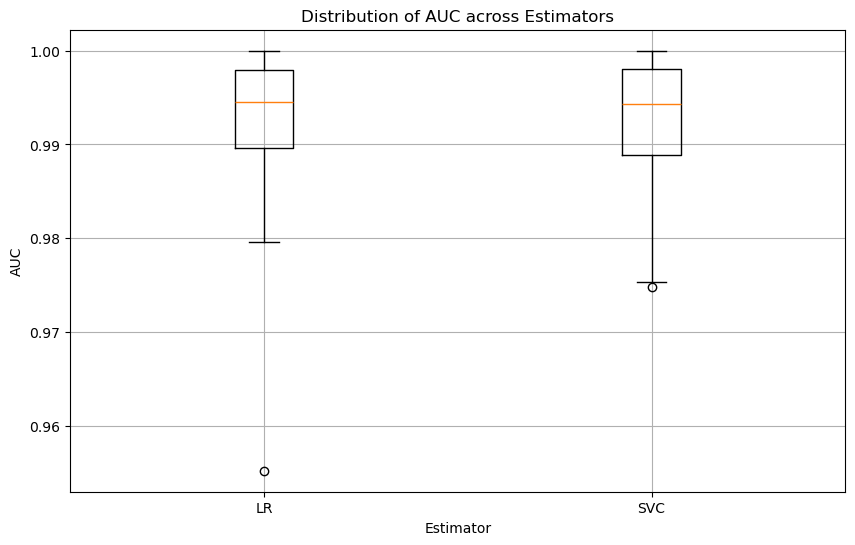

In [13]:
# Group AUC scores by estimator
grouped = df_results.groupby('estimator')['AUC'].apply(list)

# Create boxplot
plt.figure(figsize=(10, 6))
plt.boxplot(grouped.values, tick_labels=grouped.index)

plt.title('Distribution of AUC across Estimators')
plt.xlabel('Estimator')
plt.ylabel('AUC')
plt.grid(True)
plt.show()